In [1]:
# %matplotlib widget

import os
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
import shap
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import make_scorer, precision_score, recall_score, classification_report, ConfusionMatrixDisplay, f1_score, make_scorer, RocCurveDisplay
from itertools import combinations

def precision_class_0(y_true, y_pred):
    return precision_score(y_true, y_pred, average=None)[0]

def precision_class_1(y_true, y_pred):
    return precision_score(y_true, y_pred, average=None)[1]

def recall_class_0(y_true, y_pred):
    return recall_score(y_true, y_pred, average=None)[0]

def recall_class_1(y_true, y_pred):
    return recall_score(y_true, y_pred, average=None)[1]

import warnings

7033aa132a2e31989f4d19b022da42a30bb28bcea09f6282

In [2]:
os.getcwd()

'c:\\Users\\samue\\OneDrive\\Documenti\\Studio\\Università\\Tesi\\Progetto\\Ricerca\\Script\\Microarray_Script\\DatasetFull'

In [3]:
os.chdir("../../../SYMBOL/Results/DatasetFull")
# os.chdir("../store/DatasetFull")

<h2>Dataset Upload</h2>

In [4]:
dataset = pd.read_csv('../../Dataset/MergedDatasetFullCombatDeclustered_symbol.csv')
label = dataset['Label']
dataset.drop(columns=['SampleID', 'PatientID', 'Label'], inplace=True)
dataset

TRAK2   MARCHF5      AVIL    CLSTN1    TAPBPL     TRIM38     GDF11  \
0     9.597071  6.172613  6.183003  7.619254  8.451946   9.674435  6.629841   
1     9.039251  6.532620  6.350718  7.841904  8.629886   9.565077  6.824635   
2     8.791386  6.548371  6.933703  7.279164  8.166420   9.772884  6.515736   
3     9.373170  7.116801  7.012218  7.233344  8.338171   9.725869  6.458866   
4     9.076237  7.104757  6.515409  7.488312  8.355218  10.033820  6.189225   
...        ...       ...       ...       ...       ...        ...       ...   
1033  8.955028  6.642111  6.639887  7.445428  8.359939   9.682368  6.735513   
1034  9.101329  6.715089  6.611748  7.449074  8.112262   9.634445  6.503292   
1035  9.271382  6.670915  6.620238  7.404586  8.119619   9.650254  6.681918   
1036  9.351712  6.679360  6.581669  7.442222  8.282929   9.638524  6.409742   
1037  9.292476  6.678637  6.662260  7.397570  8.343229   9.653412  6.024943   

        TBXA2R     SPAST      MCM3  ...   PAK1IP1     NDUFA1      PEX7  \
0     6.700156  7.881287  8.240517  ...  7.339375  10.188925  6.535162   
1     6.727150  7.830775  8.208113  ...  7.251840  10.255465  6.432247   
2     6.363606  7.827843  8.133049  ...  7.279236  10.101372  6.495679   
3     6.108414  8.426698  8.078382  ...  7.311252  10.314306  6.353293   
4     6.473050  8.245104  8.216184  ...  7.289160  10.243407  6.334131   
...        ...       ...       ...  ...       ...        ...       ...   
1033  6.554890  8.052685  8.162122  ...  7.015461  10.312671  5.698647   
1034  6.350074  8.274160  8.296960  ...  7.259678  10.357670  6.671623   
1035  6.342317  8.287929  8.152867  ...  7.351145  10.208762  6.715863   
1036  6.433034  8.261687  8.273441  ...  7.178289  10.401224  6.861365   
1037  6.410587  8.050168  8.169079  ...  7.309705  10.255236  6.813299   

          NET1     TMED5      FADD     URGCP      MDM4    BMPR1A    EIF1AY  
0     7.816546  9.744325  8.263995  7.352167  8.662674  6.263145  5.084750  
1     7.916046  9.687447  8.241698  7.349809  8.445578  7.242537  5.046855  
2     8.104559  9.632676  8.242744  7.205897  8.071700  6.124447  5.049761  
3     7.386301  9.769748  8.376067  7.312015  8.425182  6.534315  5.051708  
4     7.331289  9.626407  8.217957  7.254979  7.917974  6.195773  5.038392  
...        ...       ...       ...       ...       ...       ...       ...  
1033  7.380776  9.698418  8.155223  7.361099  8.327890  6.361955  5.504788  
1034  7.428976  9.763741  8.122246  7.262578  8.175908  7.282642  5.622606  
1035  7.705067  9.785031  8.103883  7.362873  8.131763  7.425195  5.609163  
1036  7.413546  9.703183  8.135620  7.244212  8.187447  6.908857  5.568584  
1037  7.595989  9.750070  8.454906  7.257439  8.178654  6.913615  5.572668  

[1038 rows x 6668 columns]

<h3>Scaling</h3>

In [36]:
gradientBoosting = joblib.load("xgbDefFull.pkl")

current = dataset.copy()
current_Scaled = gradientBoosting[0].transform(current)
current_Scaled = pd.DataFrame(current_Scaled, columns=current.columns)
current_Scaled.insert(0, 'Label', label)

n = int(current_Scaled.shape[0] * 0.1)

print(n)

noMS = current_Scaled[current_Scaled['Label'] == 0].sample(n, random_state=42)
ms = current_Scaled[current_Scaled['Label'] == 1].sample(n, random_state=42)

currentBack = pd.concat([noMS, ms]).sample(frac=1, random_state=42).reset_index(drop=True)

currentBack.drop(columns=['Label'], inplace=True)
current_Scaled.drop(columns=['Label'], inplace=True)

103


<h2> SHAP Explanations</h3>

In [38]:
explainer = shap.TreeExplainer(gradientBoosting[-1], currentBack)
shap_object = explainer(current_Scaled)

shap_values = shap_object.values
shap_importance = np.abs(shap_values).mean(0)
shap_dict = dict(zip(gradientBoosting.feature_names_in_, shap_importance))
expl_sorted = dict(sorted(shap_dict.items(), key=lambda item: item[1], reverse=True))

expl_sorted

 93%|=================== | 968/1038 [00:13<00:00]       

{'ABCA1': 0.42377776283466634,
 'NDUFS5': 0.3599050004923352,
 'HLA-DRB1': 0.28484796561932874,
 'CROCC': 0.23561278175067588,
 'HLA-DRB5': 0.23398413513076485,
 'KLF3-AS1': 0.21342996862072747,
 'SPATA7': 0.21138137835470483,
 'EIF2S2': 0.2109245362167198,
 'MRFAP1L1': 0.20882398229173116,
 'DNAAF11': 0.1861498099477038,
 'MAMLD1': 0.18546270353927777,
 'FOXRED2': 0.18288684168858338,
 'LILRA2': 0.18088312908868937,
 'MUC1': 0.175282587143296,
 'SFSWAP': 0.17320766953981148,
 'CTSG': 0.17203436551048554,
 'SRSF11': 0.16574600106839119,
 'SPATA2': 0.15846233858609407,
 'CD163': 0.15371651670143674,
 'GPR68': 0.14969893733267378,
 'PPP2R1A': 0.14723453337029657,
 'ADAT1': 0.1454765385455316,
 'SEC14L1': 0.1448585185989097,
 'HDC': 0.14472861849621266,
 'CRTAP': 0.14271759805736073,
 'FKBP5': 0.14221343024269112,
 'ZNF473': 0.14084543384486664,
 'NOL11': 0.1407972638809925,
 'ERICH1': 0.14041240065139654,
 'TMX4': 0.13291124768151383,
 'RFTN1': 0.1289153791200694,
 'TMT1A': 0.12445545419

In [7]:
def addClusterGenes(geneList):
    clusters = joblib.load("uniqueClustersFull.pkl")
    for key, value in clusters.items():
        print(value, value in geneList)
        
        if value in geneList:
            insertElements = [gene for gene in key if gene != value]
            idx = geneList.index(value)
            geneList[idx+1:idx+1] = insertElements

    return geneList

shap_object = joblib.load("xgbDefFull_shapValues.pkl")
expl_sorted = joblib.load("xgbDefFull_explSorted.pkl")
feature_nonZero = [k for k, v in expl_sorted.items() if v != 0]

<h2>Explorative Graphs</h2>

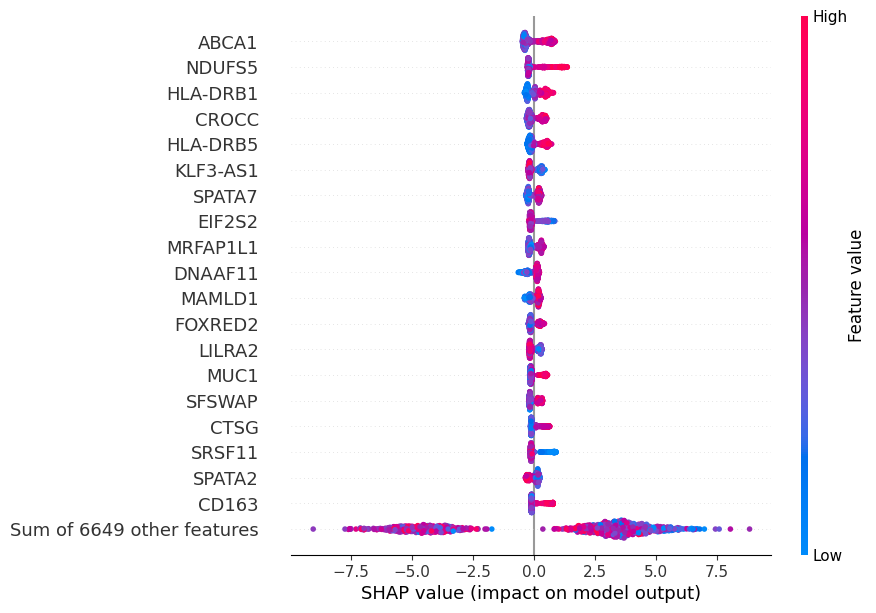

In [ ]:
plt.close()
fig, ax = plt.subplots()
shap.plots.beeswarm(shap_object, max_display=20, plot_size=(10, 7), show=False)
fig.subplots_adjust(left=0.3)

Text(0.5, 1.0, 'Top 25 features for importance')

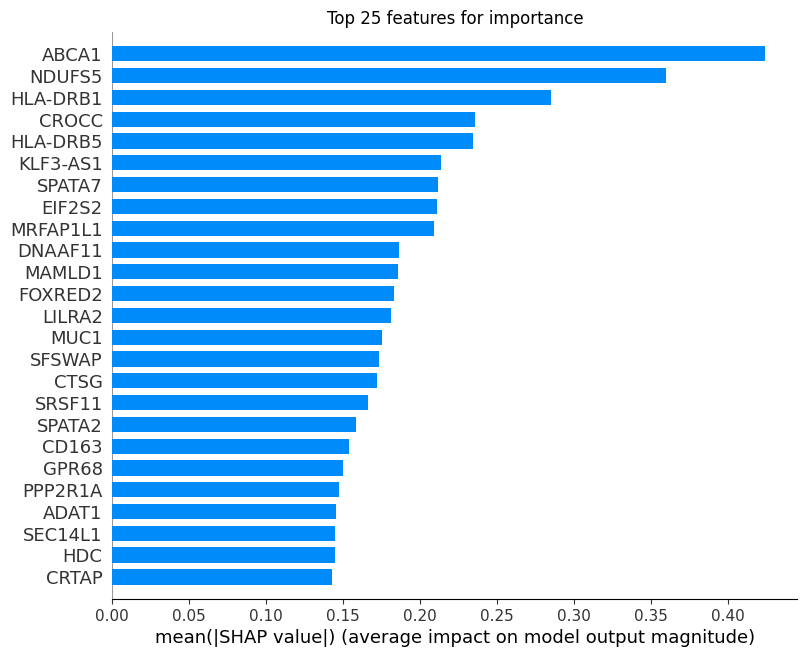

In [8]:
plt.close()
fig, ax = plt.subplots()
shap.summary_plot(shap_object, current_Scaled, max_display=25, plot_type="bar", show=False, plot_size=(10, 7))
fig.subplots_adjust(left=0.3, top=0.9)
plt.title('Top 25 features for importance')

In [25]:
cont = 0
for value in expl_sorted.values():
      if value != 0:
        cont+=1

print('Feature con importanza non zero:', cont)

Feature con importanza non zero: 724


<h3>Bar plot of importances over the two classes</h3>

In [41]:
current = current_Scaled.copy()
current.insert(0, 'Label', label)


cohorts = ["MS" if label == 1 else "Control" for label in current['Label']]
cohort_explanation = shap_object.cohorts(cohorts)
cohort_means = cohort_explanation.abs.mean(0)

cohort_df = pd.DataFrame({
    'MS': cohort_explanation.cohorts['MS'].values.mean(0),  # Media per MS
    'Control': cohort_explanation.cohorts['Control'].values.mean(0)  # Media per Control
}, index=current_Scaled.columns)  # Usa le feature come indice

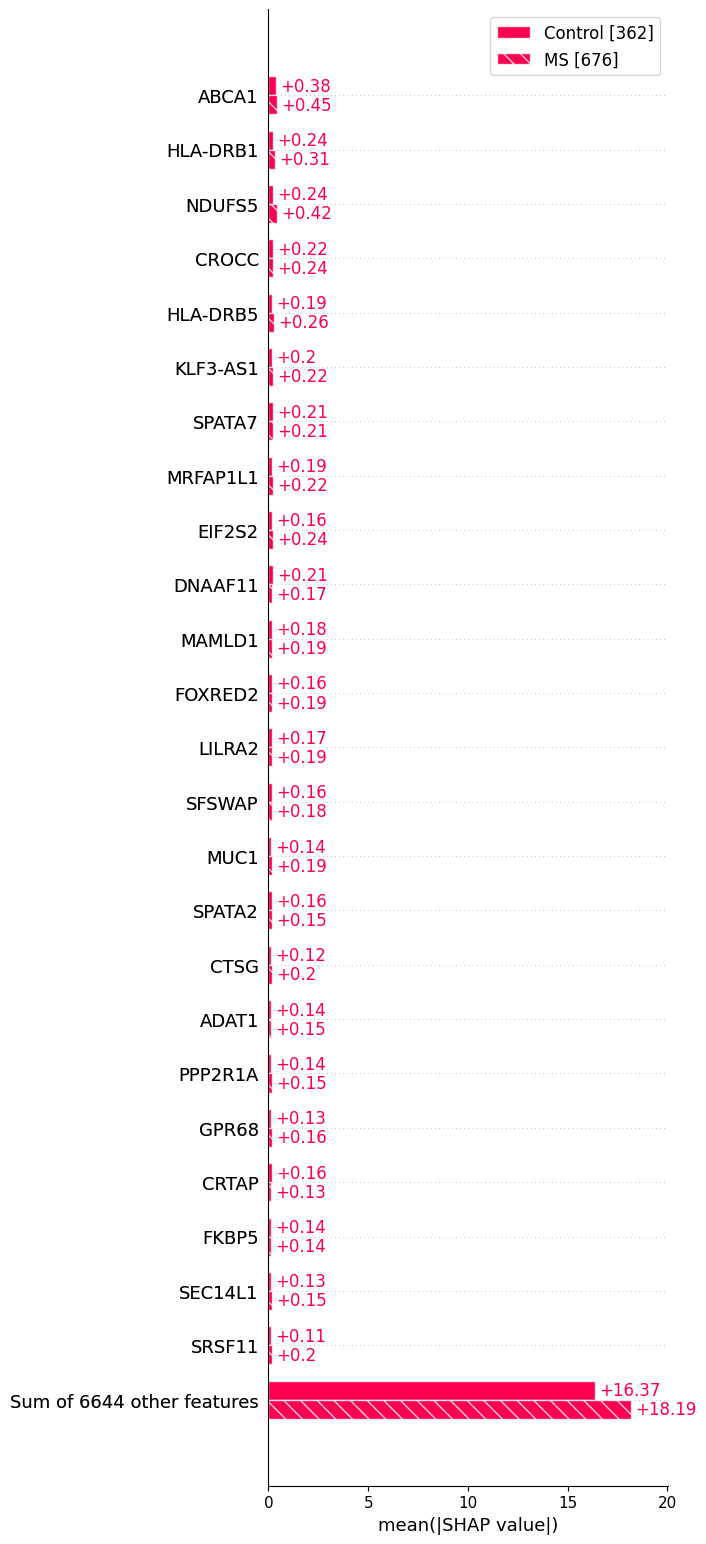

In [42]:
plt.close()
fig, ax = plt.subplots(figsize=(10, 5))
shap.plots.bar(cohort_means, max_display=25, show=False)
fig.subplots_adjust(left=0.4)

Showing the genes where the importance for the class MS is higher than a value epsilon compared to the importance of the Control class

In [ ]:
diff = np.abs(cohort_df['MS'] - cohort_df['Control'])

Difference importance between classes distribution

In [74]:
diff_mean = np.mean(diff)
diff_meadian = np.median(diff)
diff_std = np.std(diff)

print('Mean:', diff_mean)
print('Median:', diff_meadian)
print('Stadnard Deviation:', diff_std)
k=0
bestFeatures = [key for key, value in expl_sorted.items() if value > (k*diff_std)+diff_mean]
print(f"Number of features over {k} sigma:", len(bestFeatures), bestFeatures)

Mean: 0.0015801895843965818
Median: 0.0
Stadnard Deviation: 0.0093722805111605
Number of features over 0 sigma: 715 ['ABCA1', 'NDUFS5', 'HLA-DRB1', 'CROCC', 'HLA-DRB5', 'KLF3-AS1', 'SPATA7', 'EIF2S2', 'MRFAP1L1', 'DNAAF11', 'MAMLD1', 'FOXRED2', 'LILRA2', 'MUC1', 'SFSWAP', 'CTSG', 'SRSF11', 'SPATA2', 'CD163', 'GPR68', 'PPP2R1A', 'ADAT1', 'SEC14L1', 'HDC', 'CRTAP', 'FKBP5', 'ZNF473', 'NOL11', 'ERICH1', 'TMX4', 'RFTN1', 'TMT1A', 'ING2', 'HUWE1', 'OSBPL1A', 'FANCL', 'CDC42', 'SIAH1', 'RCC1', 'FUZ', 'ZNF432', 'DBN1', 'HBD', 'ACO2', 'EIF4G1', 'TAF6', 'GORASP1', 'FGGY', 'SPART', 'BCAS4', 'CD151', 'ZBTB5', 'COX20', 'COX14', 'DEDD', 'LRP1', 'SSTR2', 'SLC35B1', 'MARCHF6', 'PPP2R5D', 'RMC1', 'AP1S1', 'CSNK2A2', 'RRP7A', 'EIF3A', 'TIMM10', 'DUSP2', 'ABCC5', 'CLN8', 'DYNC1LI2', 'EPHA1', 'TCEAL2', 'RNF146', 'ZC3HAV1', 'NDUFA5', 'H2BC21', 'FARSA', 'LAPTM4B', 'NADK', 'EPHB1', 'TM9SF1', 'EHD1', 'POLD3', 'DDIT4', 'GALNT6', 'PFKP', 'DNAJA3', 'MT1F', 'RNF24', 'EIF3H', 'FAF2', 'QSOX1', 'RBMS2', 'PLK4', 'FA

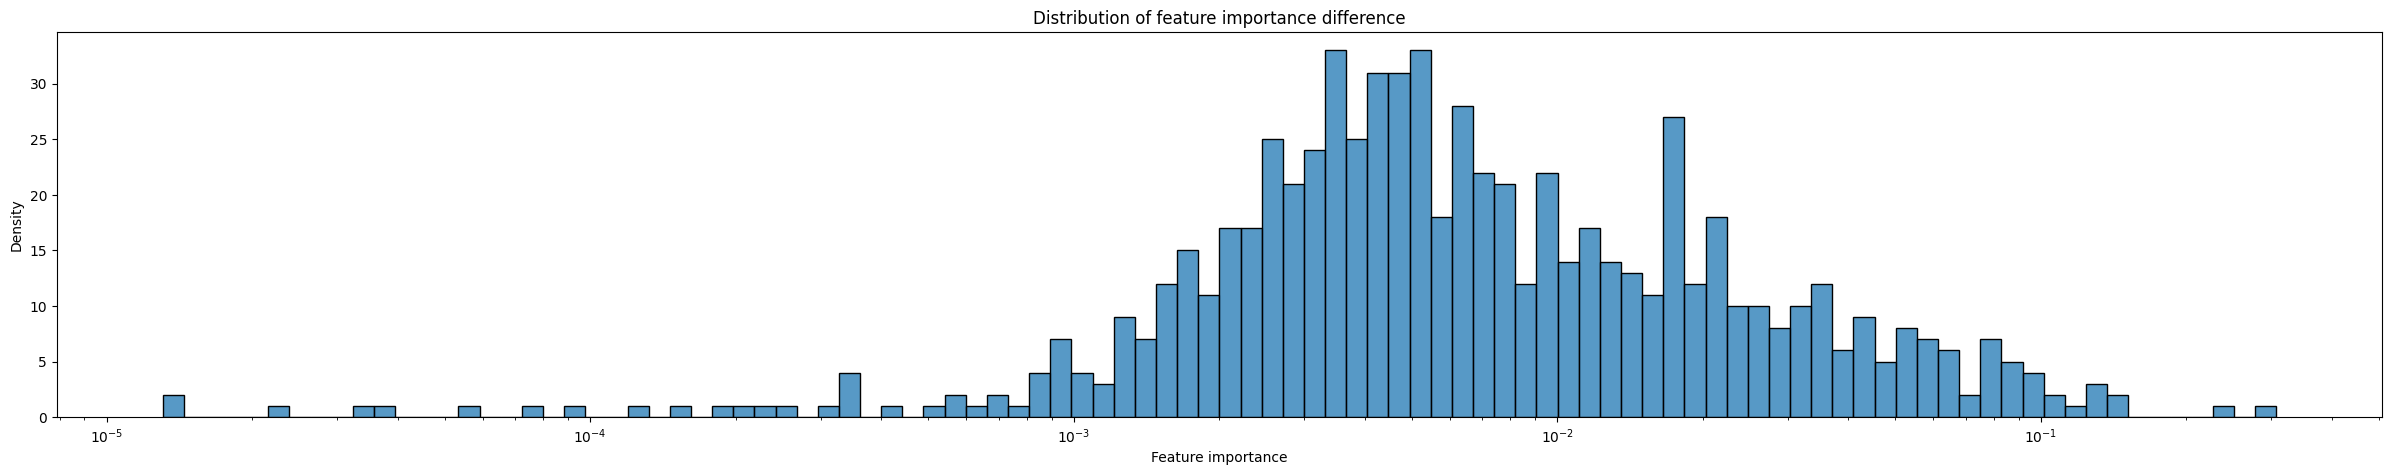

In [79]:
plt.close()
plt.figure(figsize=(30,5))
sns.histplot(data=diff, bins=100, log_scale=True)
plt.title('Distribution of feature importance difference')
plt.xlabel('Feature importance')
plt.ylabel('Density')
plt.show()

In [72]:
epsilon = 0.01  # Modifica questo valore
significant_features = diff[diff >= epsilon].index.tolist()

print(f"Feature con differenza >= {epsilon}:")
significant_featuresEnriched = addClusterGenes(significant_features)
print(len(significant_featuresEnriched), significant_featuresEnriched)

Feature con differenza >= 0.01:
EIF1AY False
245 ['LPCAT3', 'HBD', 'PPP2R5D', 'HEATR6', 'BTRC', 'POLD3', 'QSOX1', 'GORASP1', 'PATJ', 'RBMS2', 'PPP3R1', 'CTSG', 'FAAH', 'AQP3', 'CTSK', 'H2AC8', 'CDKN1B', 'NREP', 'CRTAP', 'TIMM10', 'GARS1', 'TBC1D9B', 'MRFAP1L1', 'P4HA1', 'TMX4', 'RMC1', 'MARCHF6', 'STRN', 'ABCA1', 'RPL14', 'EIF3A', 'ITK', 'FGGY', 'BID', 'MICU1', 'BORA', 'FARSA', 'GBP2', 'LILRA3', 'GNAI3', 'HADHA', 'CACNA2D2', 'ERICH1', 'KLF3-AS1', 'LAPTM4B', 'SRSF11', 'ADAT1', 'TXNRD1', 'RAPGEF1', 'TIMM13', 'GPR68', 'PANK4', 'EIF2AK2', 'ZNF432', 'FAF2', 'CD163', 'RNF24', 'PLK4', 'RBM6', 'RCC1', 'TAF1', 'CD151', 'SPART', 'ASCC1', 'EZH1', 'CROCC', 'PPP2CB', 'LILRA2', 'ITM2C', 'APOC1', 'DYRK2', 'FTH1', 'TMEM143', 'SLC35B1', 'NMRK1', 'AHI1', 'COTL1', 'TRIM3', 'KLF4', 'EGR1', 'TM9SF1', 'PSMB9', 'ABCC5', 'LPAR6', 'NECTIN1', 'PTPN6', 'RNF146', 'LTA4H', 'ZNF143', 'FEZ1', 'KLRG1', 'KRAS', 'IK', 'NEDD8', 'P3H2', 'WWP2', 'PLLP', 'AGO2', 'MUC1', 'RFTN1', 'EHD1', 'CBR1', 'CENPB', 'MSL3', 'PMP22', 'P

<h3>Dependence plot with interactions for the 2 known gene of the family HLA</h3>

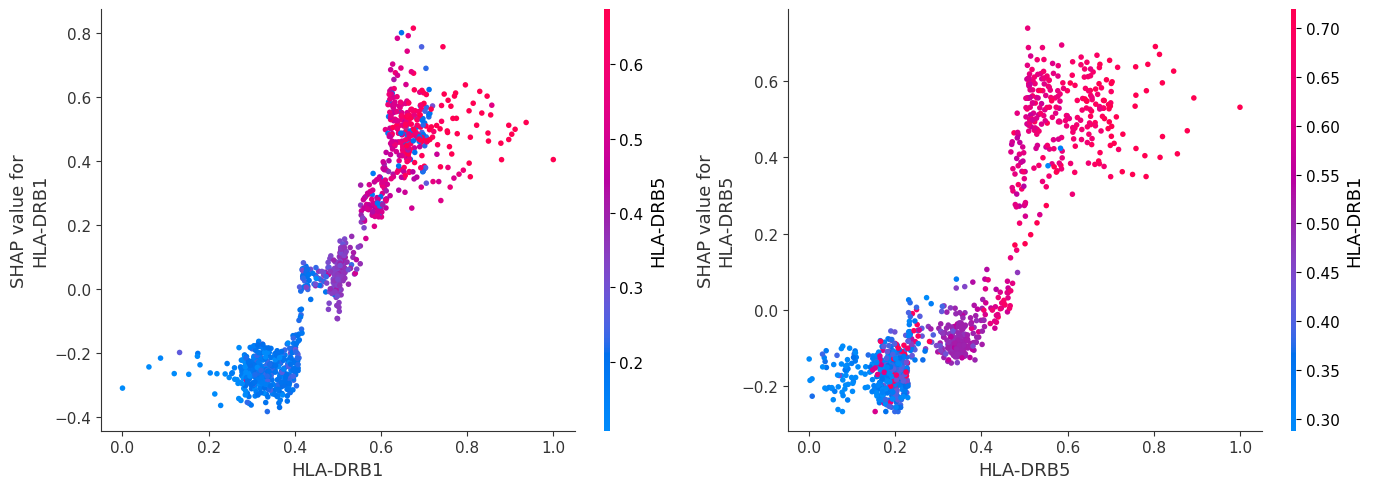

In [29]:
shap_values = shap_object.values

plt.close()
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
shap.dependence_plot("HLA-DRB1", shap_values, current_Scaled, show=False, interaction_index='HLA-DRB5', ax=ax[0])
shap.dependence_plot("HLA-DRB5", shap_values, current_Scaled, show=False, interaction_index='HLA-DRB1', ax=ax[1])
plt.tight_layout()  # Migliora lo spacing

<h3>Dependence plot of the first 20 features for importance</h3>

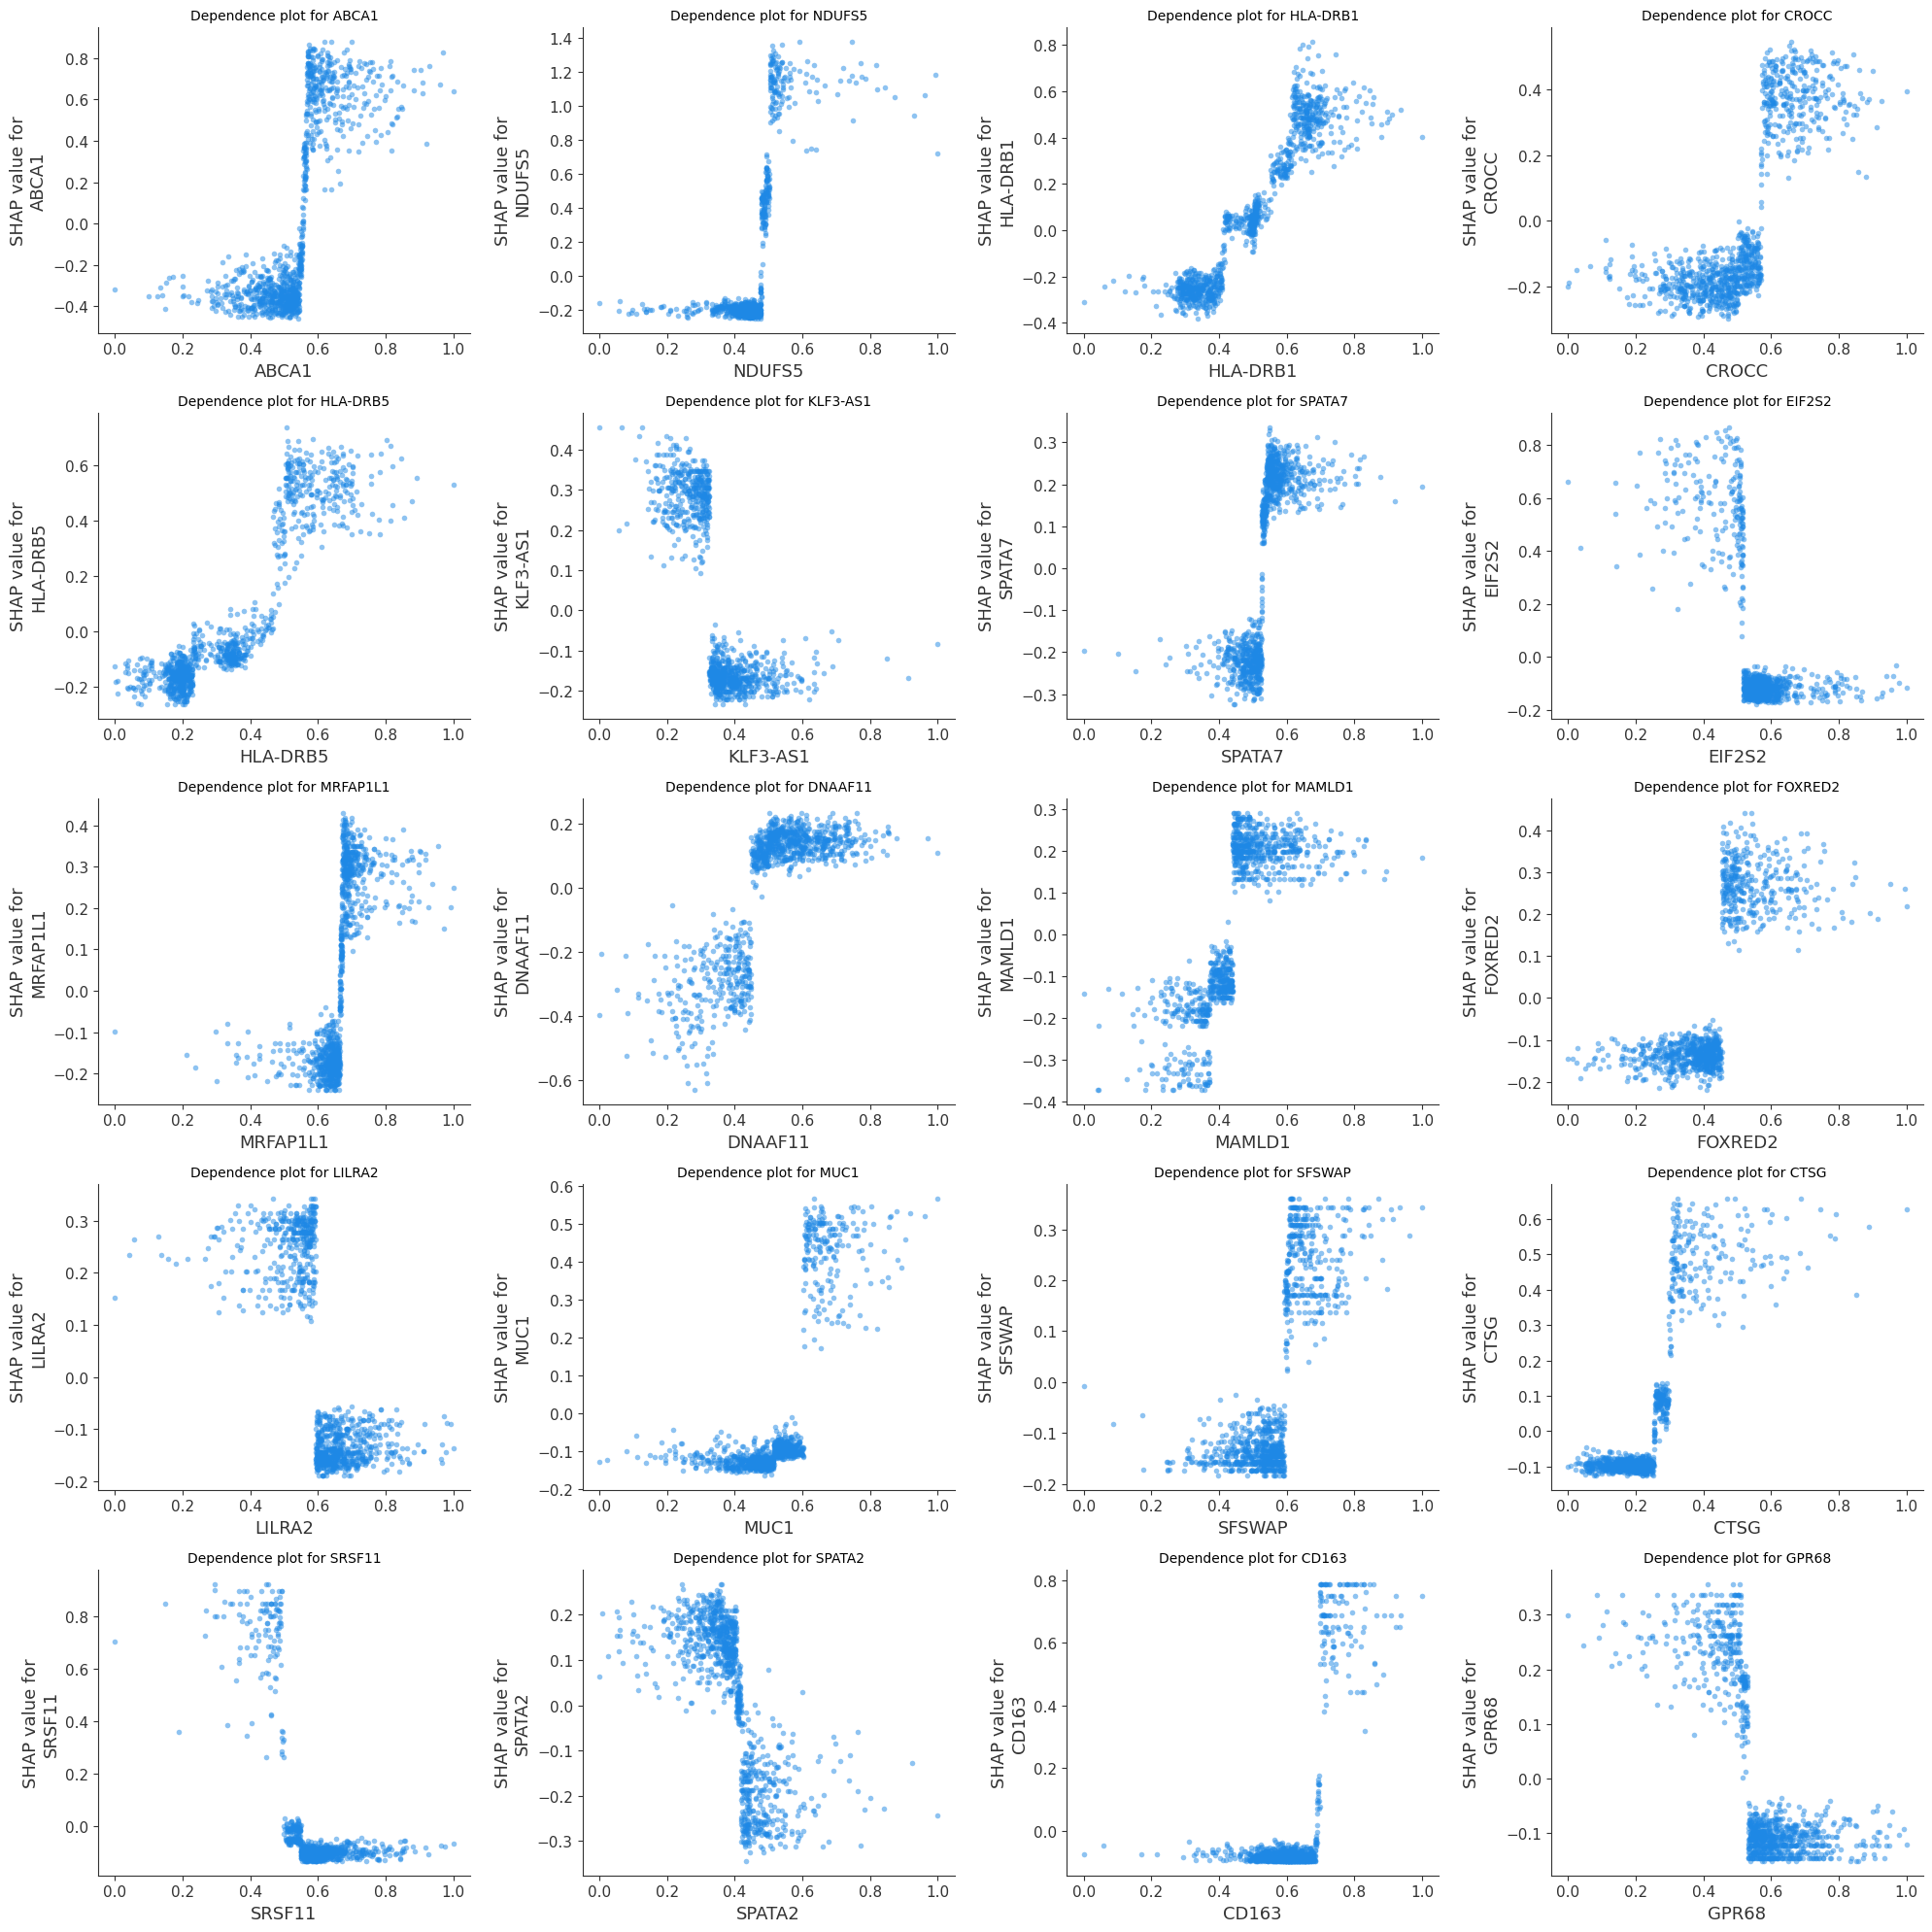

In [30]:
plt.close()

n = 5
fig, axes = plt.subplots(n, 4, figsize=(20, 20))  # Dimensioni figura
axes = axes.flatten()  # Appiattisci l'array di assi per iterare

features = list(expl_sorted.keys())[:20]  # Prendi le prime 4 features

# Loop sulle features
for i, feature in enumerate(features):
    if i >= len(axes):  # Evita errori se troppe features
        break
    shap.dependence_plot(
        feature,
        shap_values,  # Usa .values se shap_values è un Explanation object
        current_Scaled,      # Il tuo DataFrame (o array)
        interaction_index=None,
        ax=axes[i],          # Specifica l'asse corrente
        alpha=0.5,
        show=False
    )
    
    axes[i].set_title(f'Dependence plot for {feature}', fontsize=10)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Migliora lo spacing
plt.show()

<h3>Dependence plot with interactions beetween the combination of the first 5 features for importance</h3>

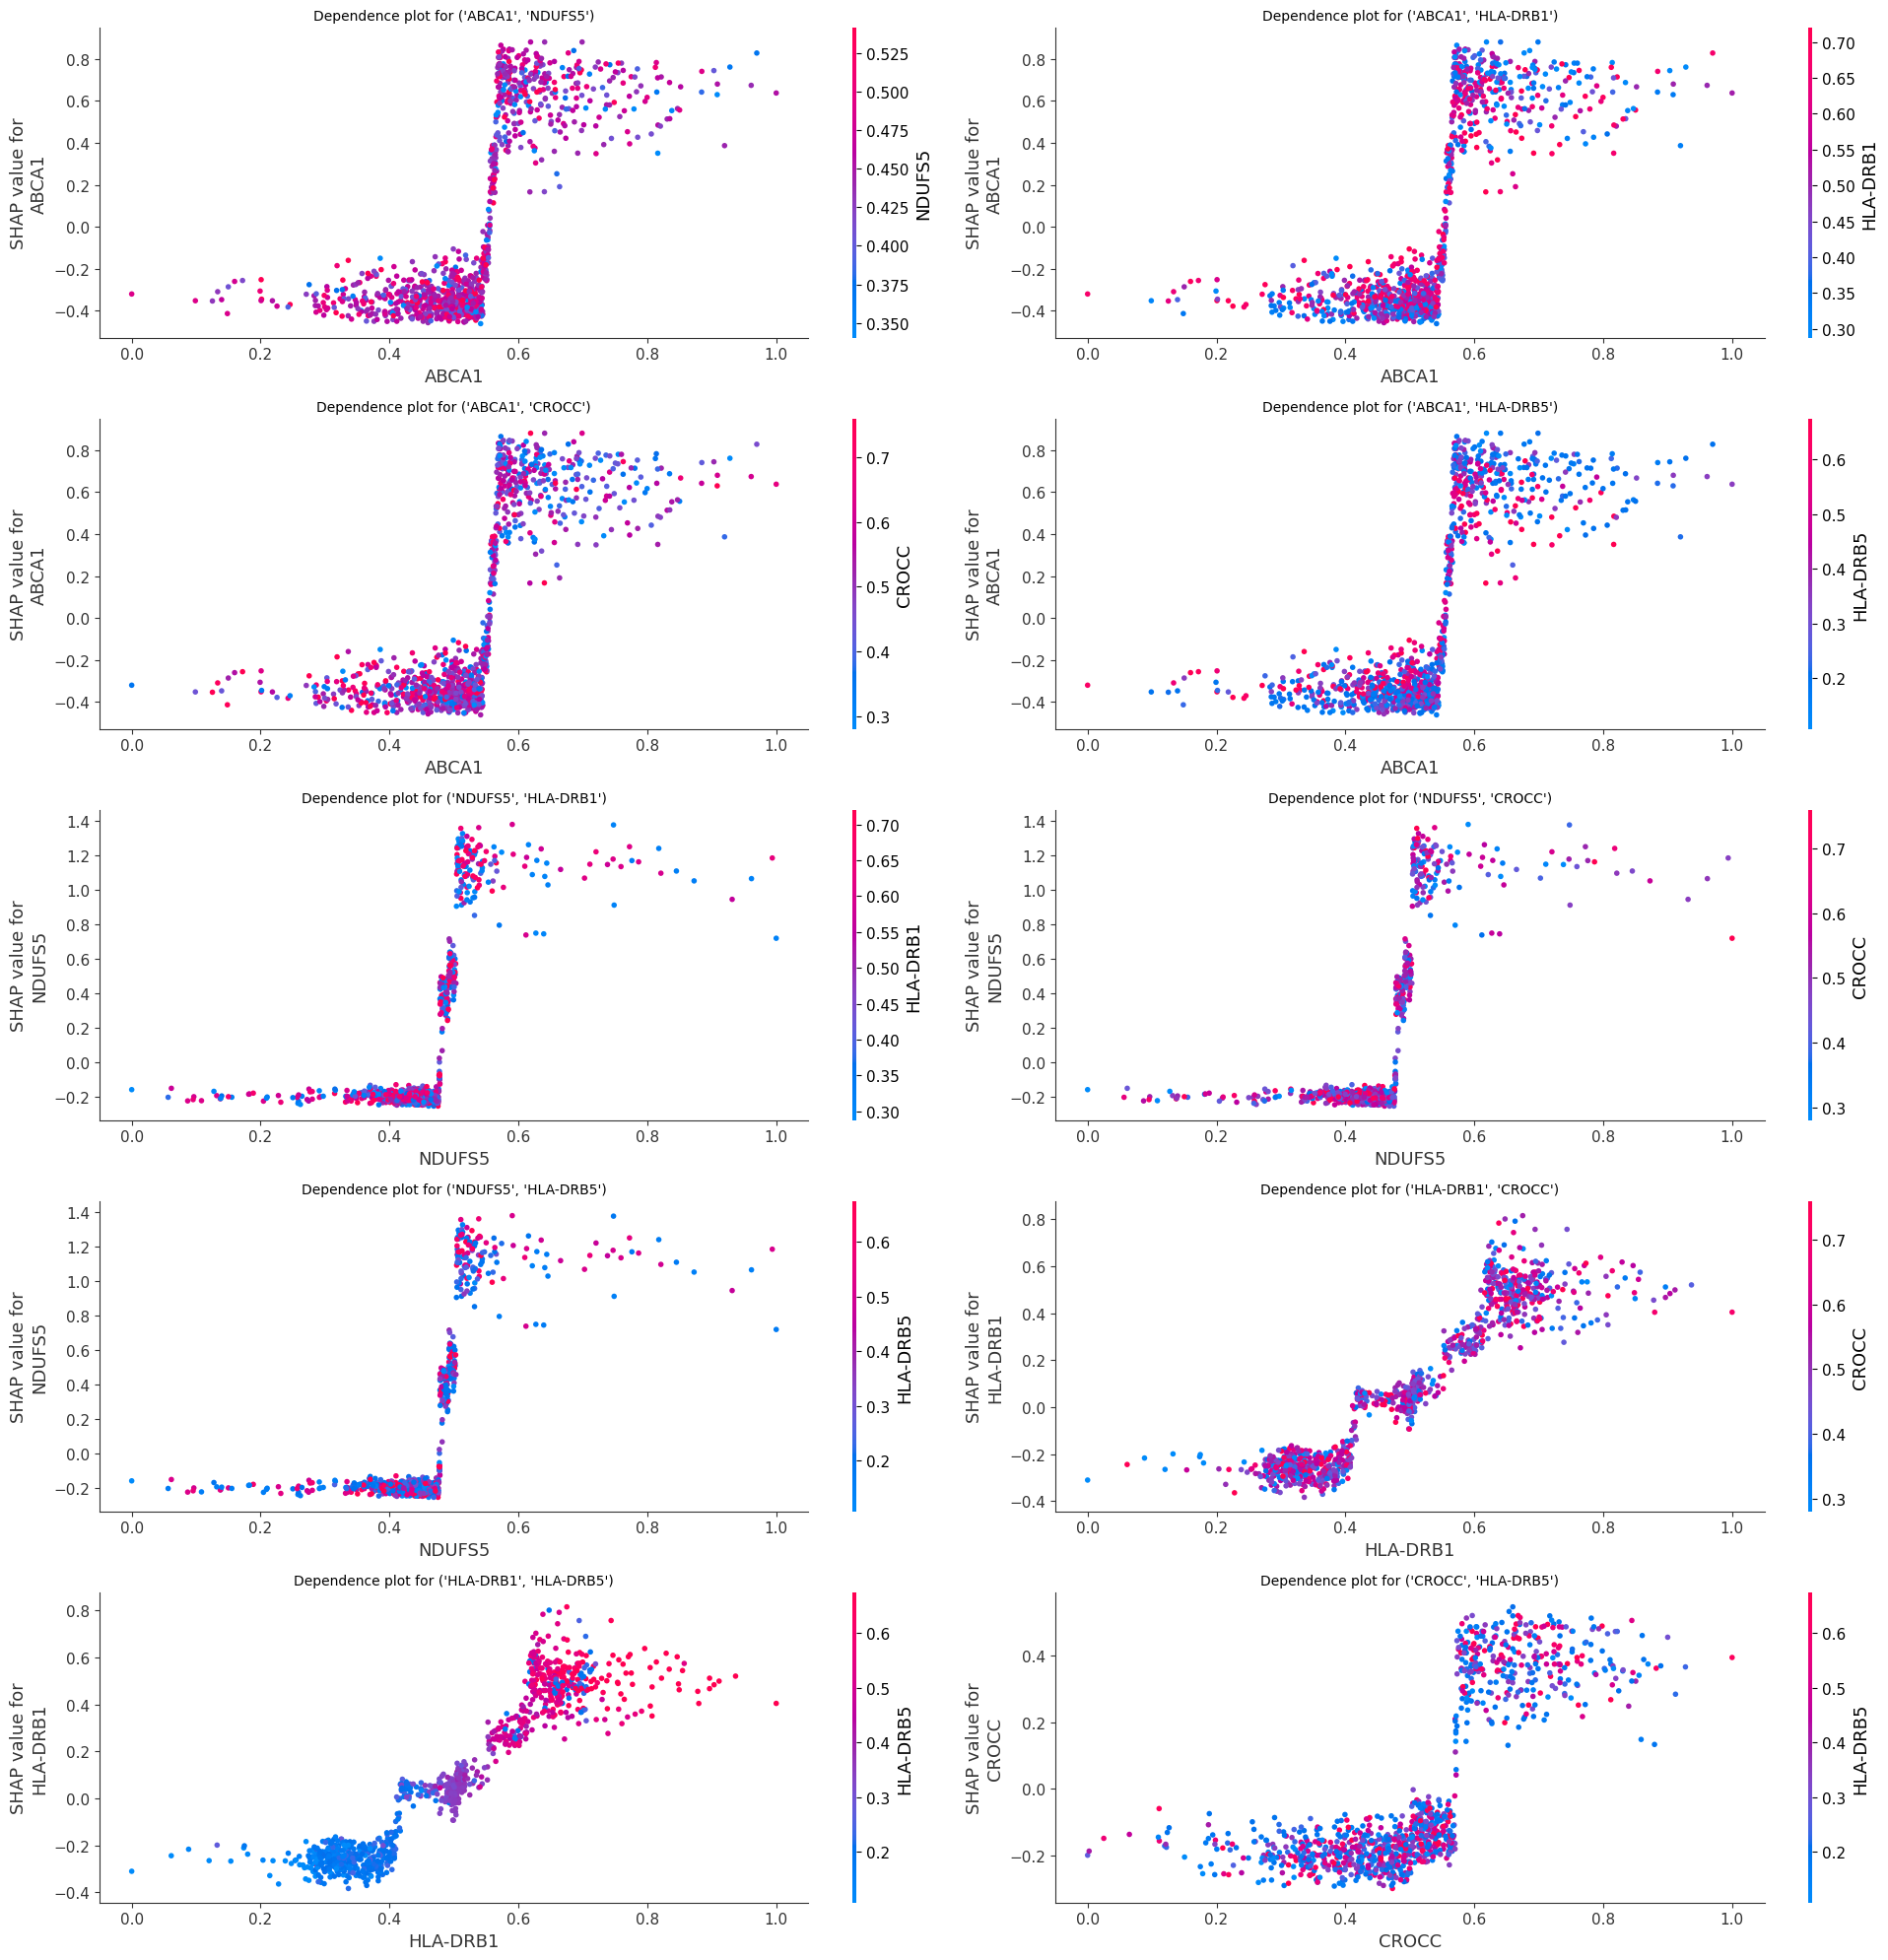

In [34]:
plt.close()

n = 5
fig, axes = plt.subplots(n, 2, figsize=(20, 20))  # Dimensioni figura
axes = axes.flatten()  # Appiattisci l'array di assi per iterare

features = list(expl_sorted.keys())[:5]  # Prendi le prime 4 features
featuresCoupled = list(combinations(features, 2))

# Loop sulle features
for i, feature in enumerate(featuresCoupled):
    if i >= len(axes):  # Evita errori se troppe features
        break
    shap.dependence_plot(
        feature[0],
        shap_values,  # Usa .values se shap_values è un Explanation object
        current_Scaled,      # Il tuo DataFrame (o array)
        interaction_index=feature[1],
        ax=axes[i],          # Specifica l'asse corrente
        alpha=1,
        show=False
    )
    
    axes[i].set_title(f'Dependence plot for {feature}', fontsize=10)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Migliora lo spacing
plt.show()

<h3>Shap correlation between top genes</h3>

In [ ]:
current = current_Scaled.copy()
current.insert(0, 'Label', label)
# current = current.sample(frac=0.4, random_state=42)
currentLabel = current['Label']
current = current[[key for key, value in expl_sorted.items() if value != 0][:100]]

clustering = shap.utils.hclust(current, currentLabel, random_state=42)
joblib.dump(clustering, "xgbDefFull_HCclusteringSHAP.pkl")
# shap.plots.bar(shap_values, clustering=clustering)

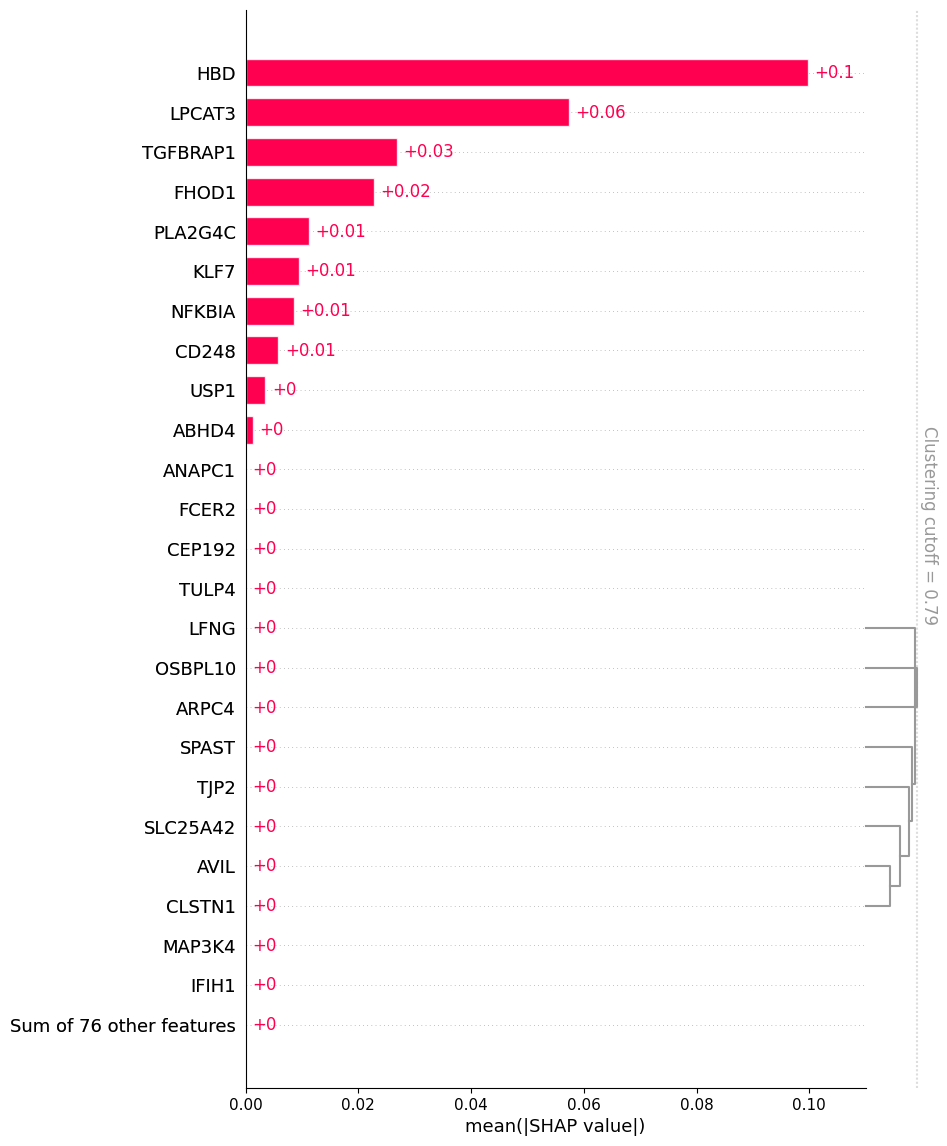

In [119]:
shap.plots.bar(shap_object[:, :100], clustering=clustering, clustering_cutoff=0.79, max_display=25)

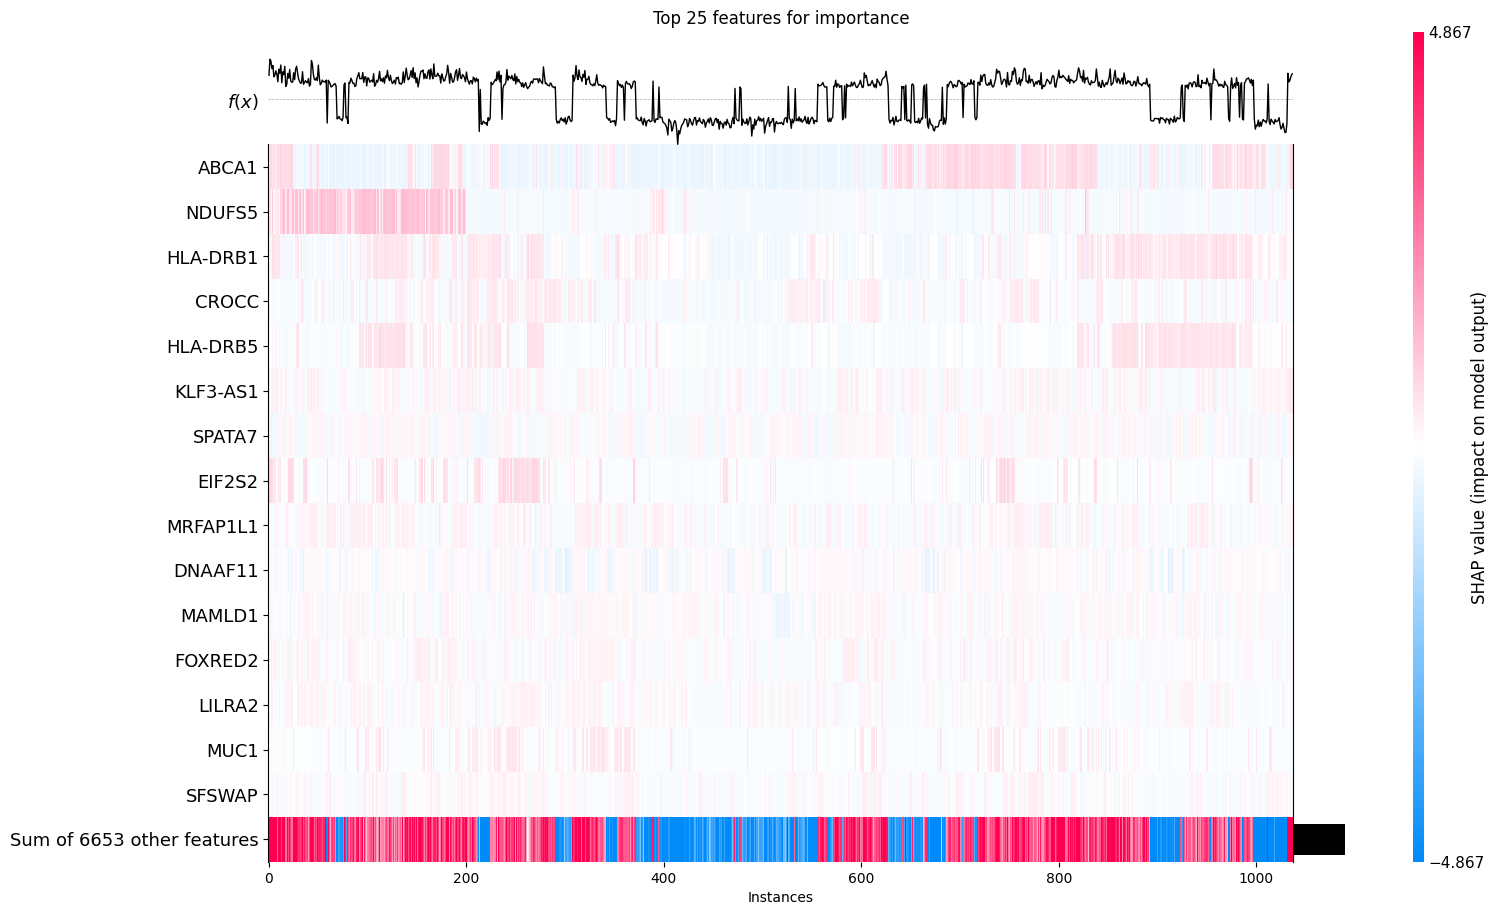

In [51]:
plt.close()
fig, ax = plt.subplots()
shap.plots.heatmap(shap_object, max_display=16, show=False, plot_width=20)
fig.subplots_adjust(left=0.3, top=0.9)
plt.title('Top 15 features for importance')
plt.show()

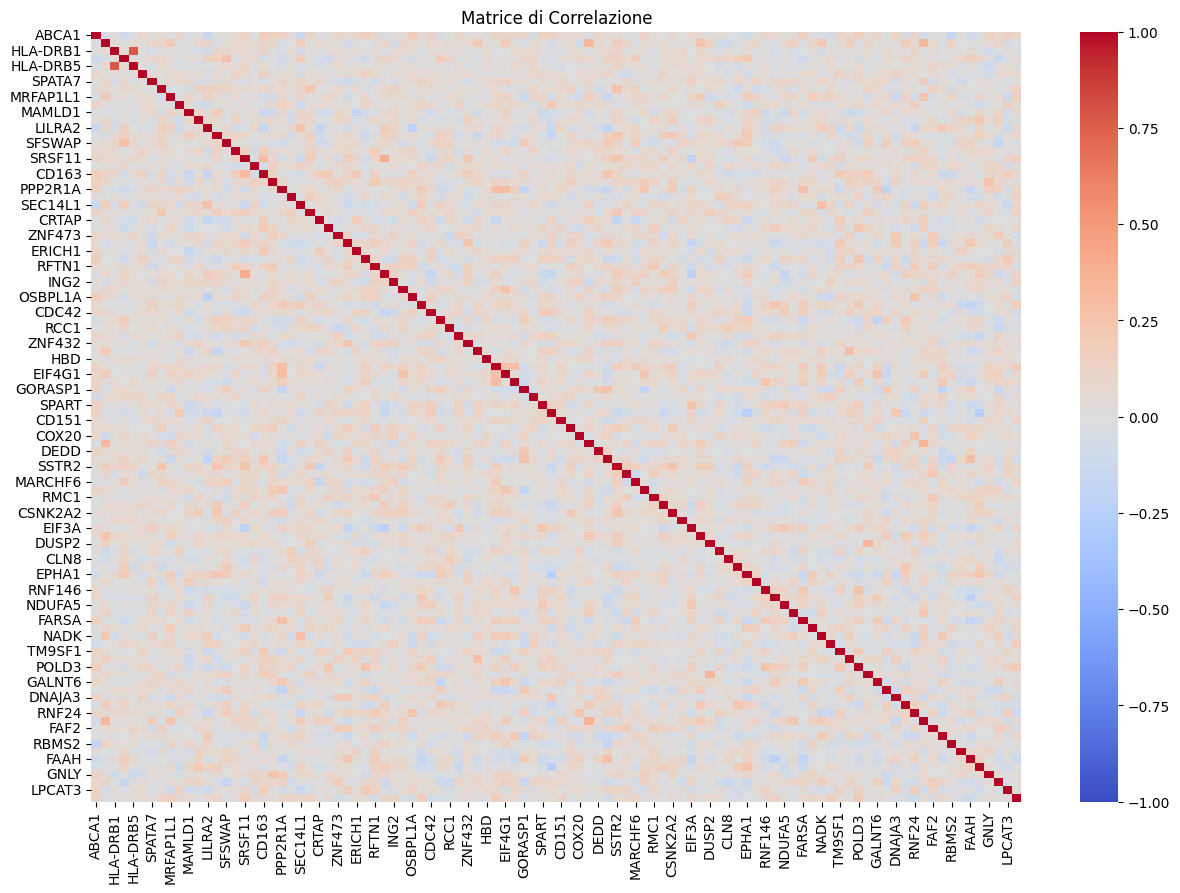

In [ ]:
shapCorr = pd.DataFrame(shap_object.values, columns=dataset.columns)[list(expl_sorted.keys())[:100]].corr()

plt.figure(figsize=(15,10))
sns.heatmap(shapCorr, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Matrice di Correlazione')
plt.show()

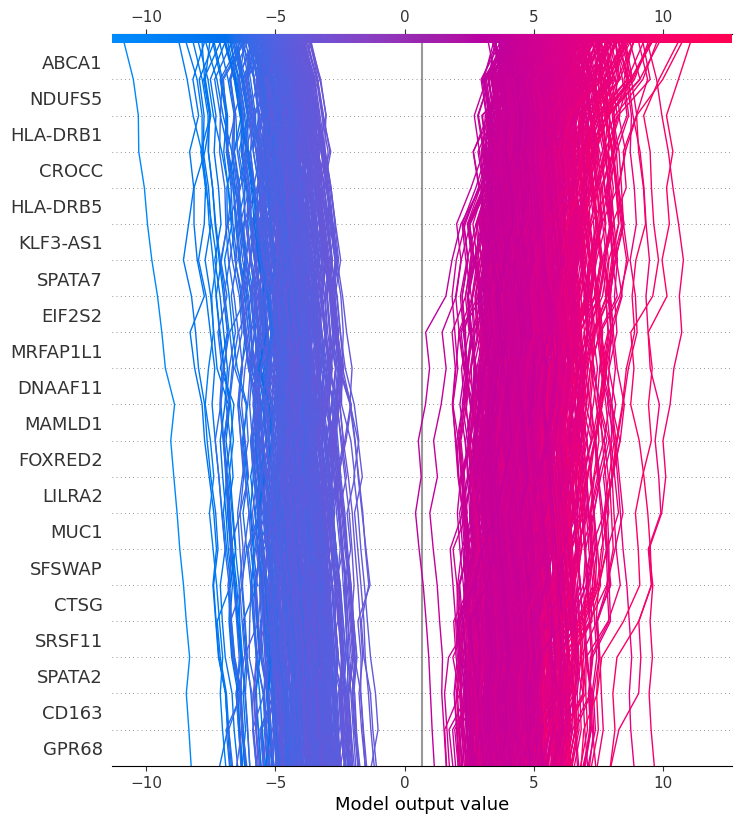

In [56]:
shap.decision_plot(explainer.expected_value, shap_values, current_Scaled)

<h3>Distribution of feature importances</h3>

Mean: 0.030925875462513325
Stadnard Deviation: 0.04246750068373472
Number of features of 0 sigma: 205 ['ABCA1', 'NDUFS5', 'HLA-DRB1', 'CROCC', 'HLA-DRB5', 'KLF3-AS1', 'SPATA7', 'EIF2S2', 'MRFAP1L1', 'DNAAF11', 'MAMLD1', 'FOXRED2', 'LILRA2', 'MUC1', 'SFSWAP', 'CTSG', 'SRSF11', 'SPATA2', 'CD163', 'GPR68', 'PPP2R1A', 'ADAT1', 'SEC14L1', 'HDC', 'CRTAP', 'FKBP5', 'ZNF473', 'NOL11', 'ERICH1', 'TMX4', 'RFTN1', 'TMT1A', 'ING2', 'HUWE1', 'OSBPL1A', 'FANCL', 'CDC42', 'SIAH1', 'RCC1', 'FUZ', 'ZNF432', 'DBN1', 'HBD', 'ACO2', 'EIF4G1', 'TAF6', 'GORASP1', 'FGGY', 'SPART', 'BCAS4', 'CD151', 'ZBTB5', 'COX20', 'COX14', 'DEDD', 'LRP1', 'SSTR2', 'SLC35B1', 'MARCHF6', 'PPP2R5D', 'RMC1', 'AP1S1', 'CSNK2A2', 'RRP7A', 'EIF3A', 'TIMM10', 'DUSP2', 'ABCC5', 'CLN8', 'DYNC1LI2', 'EPHA1', 'TCEAL2', 'RNF146', 'ZC3HAV1', 'NDUFA5', 'H2BC21', 'FARSA', 'LAPTM4B', 'NADK', 'EPHB1', 'TM9SF1', 'EHD1', 'POLD3', 'DDIT4', 'GALNT6', 'PFKP', 'DNAJA3', 'MT1F', 'RNF24', 'EIF3H', 'FAF2', 'QSOX1', 'RBMS2', 'PLK4', 'FAAH', 'PLLP', '

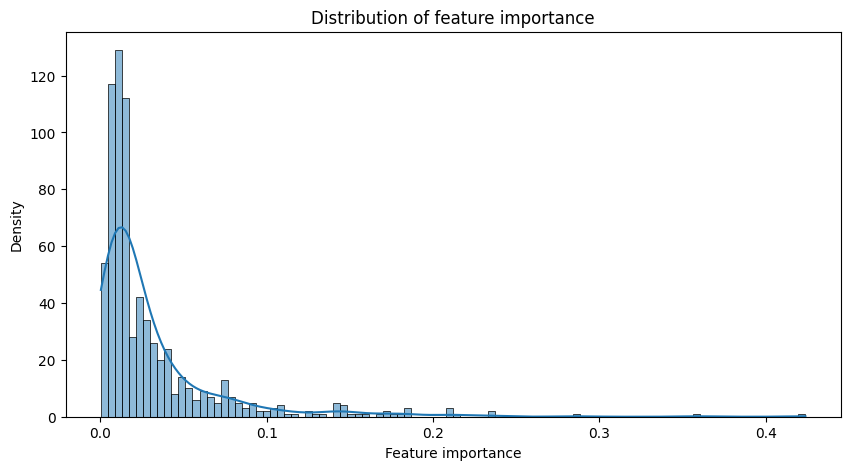

In [15]:
non_zeroShap = [value for value in expl_sorted.values() if value != 0]
mean = np.mean(non_zeroShap)
std = np.std(non_zeroShap)

print('Mean:', mean)
print('Stadnard Deviation:', std)
k=0
bestFeatures = [key for key, value in expl_sorted.items() if value > (k*std)+mean]
print(f"Number of features of {k} sigma:", len(bestFeatures), bestFeatures)

plt.close()
plt.figure(figsize=(10,5))
sns.histplot(data=non_zeroShap, bins=100, kde=True)
plt.title('Distribution of feature importance')
plt.xlabel('Feature importance')
plt.ylabel('Density')
plt.show()

<h3>Cumulative Importance</h3>

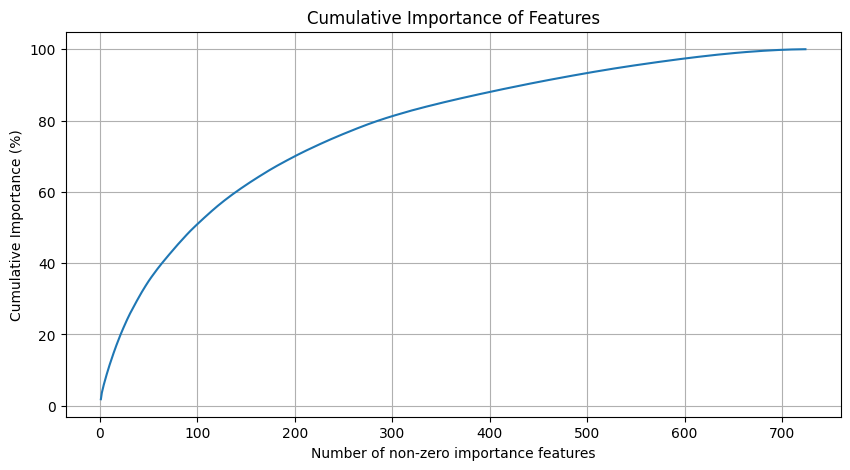

In [7]:
non_zeroShap = [value for value in expl_sorted.values() if value != 0]
cumulativeImportance = (np.array(non_zeroShap).cumsum() / np.array(non_zeroShap).sum()) * 100

plt.close()
plt.figure(figsize=(10,5))
plt.plot(range(1, len(cumulativeImportance)+1), cumulativeImportance)
plt.xlabel('Number of non-zero importance features')
plt.ylabel('Cumulative Importance (%)')
plt.title('Cumulative Importance of Features')
plt.grid()
plt.show()

In [100]:
print(list(expl_sorted.keys())[:300])

['ABCA1', 'NDUFS5', 'HLA-DRB1', 'HLA-DRB5', 'CROCC', 'KLF3-AS1', 'SPATA7', 'MRFAP1L1', 'EIF2S2', 'CTSG', 'LILRA2', 'MAMLD1', 'FOXRED2', 'SRSF11', 'MUC1', 'CD163', 'SFSWAP', 'DNAAF11', 'SPATA2', 'SEC14L1', 'ADAT1', 'TMX4', 'CRTAP', 'GPR68', 'PPP2R1A', 'NOL11', 'HDC', 'FKBP5', 'RFTN1', 'ZNF473', 'ERICH1', 'FANCL', 'TMT1A', 'ING2', 'FUZ', 'HUWE1', 'ZNF432', 'OSBPL1A', 'RCC1', 'TAF6', 'ACO2', 'NADK', 'DBN1', 'SIAH1', 'FGGY', 'EIF4G1', 'CDC42', 'HBD', 'GORASP1', 'ZBTB5', 'CD151', 'BCAS4', 'COX14', 'CSNK2A2', 'DDIT4', 'LRP1', 'DUSP2', 'RMC1', 'CLN8', 'SSTR2', 'SPART', 'EIF3A', 'SLC35B1', 'ZC3HAV1', 'IFT88', 'LAPTM4B', 'MARCHF6', 'DEDD', 'AP1S1', 'TIMM10', 'EPHA1', 'PPP2R5D', 'TCEAL2', 'EHD1', 'ABCC5', 'DYNC1LI2', 'QSOX1', 'FARSA', 'COX20', 'EPHB1', 'ZNF80', 'DNAJA3', 'EIF3H', 'CHAF1A', 'NDUFA5', 'IL32', 'H2BC21', 'MT1F', 'TM9SF1', 'GALNT6', 'POLD3', 'RRP7A', 'RBMS2', 'PFKP', 'FAAH', 'WWP2', 'EIF2AK2', 'KIAA0408', 'PLLP', 'RNF24', 'ZNF551', 'SDK2', 'LPCAT1', 'GNLY', 'FEZ1', 'LPCAT3', 'PSMB9',

<h3>SHAP vs DEA graph</h3>

In [5]:
dea_genes = joblib.load("deaGenesFull.pkl")
sorted_dea_genes = dict(sorted(dea_genes.items(), key=lambda item: item[1]))
print(len(dea_genes.keys()), list(dea_genes.keys()))

1229 ['CLSTN1', 'OSBP', 'EHMT1', 'BPI', 'EMC2', 'HBD', 'AP3B1', 'ATP6V0B', 'OSBPL10', 'C2orf42', 'NECTIN2', 'BLVRA', 'IL15', 'GCLC', 'CD248', 'MRPL22', 'ZNF580', 'YARS2', 'EMC10', 'PTBP1', 'PPP2R5D', 'S100A12', 'RBM26', 'PCID2', 'C14orf93', 'PSMB3', 'NUP98', 'STX10', 'MED17', 'HEATR6', 'TSPAN13', 'DCTN3', 'UPF3B', 'MEF2D', 'ATP5MG', 'POLR2K', 'SWAP70', 'BTRC', 'FASLG', 'PBRM1', 'POFUT2', 'CMKLR1', 'CRTAM', 'CDC5L', 'PLGRKT', 'ARHGEF18', 'UEVLD', 'DGKA', 'RNGTT', 'GORASP1', 'NPC1', 'IP6K2', 'ITGB2', 'HEBP1', 'ZNF254', 'ALDH8A1', 'POLDIP3', 'SASH1', 'WBP4', 'IL16', 'SPARC', 'CTSG', 'PIK3R5', 'USP7', 'NDUFA8', 'NSMCE4A', 'UBE2E1', 'FAAH', 'ADGRE5', 'GTF3C1', 'NR1D2', 'GSDMD', 'CSF1R', 'DENND5A', 'CAPN5', 'UAP1L1', 'MS4A1', 'ZNF224', 'SLBP', 'NQO2', 'USP11', 'EAF2', 'NPFF', 'KCNK12', 'GTF2A2', 'ZNF706', 'H2AC8', 'SUPT16H', 'SPATS2L', 'VCL', 'TBC1D5', 'CXCR4', 'DIDO1', 'RFX1', 'TOMM22', 'USPL1', 'GTF3C2', 'UBE2N', 'RFWD3', 'RAB11FIP2', 'SF3B5', 'NREP', 'NDUFB8', 'OPLAH', 'CRTAP', 'VNN2', 'I

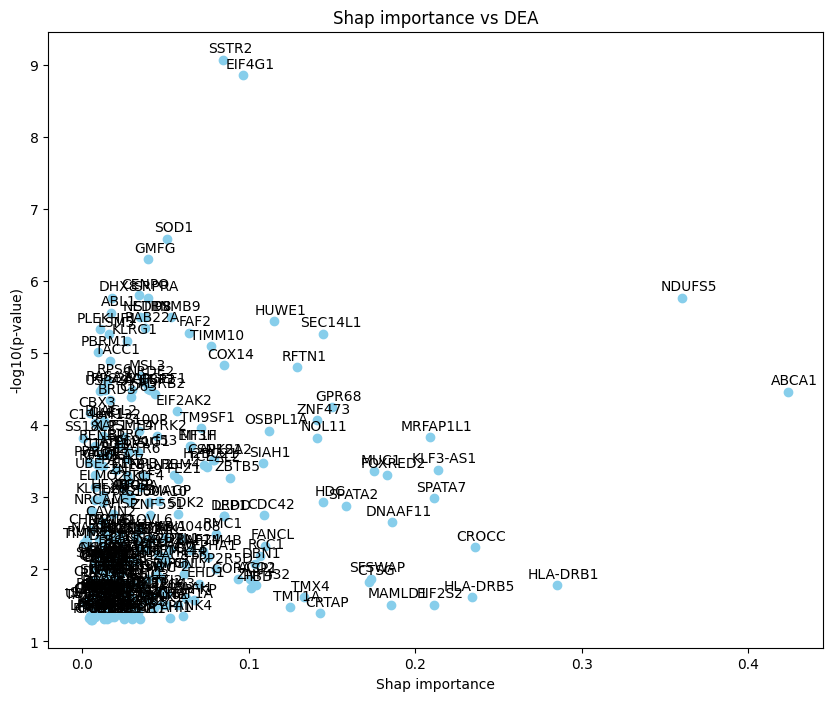

In [20]:
point_x = []
point_y = []

for gene, value in expl_sorted.items():
    if value > 0 and gene in dea_genes.keys():
        point_x.append(expl_sorted[gene])
        point_y.append(-np.log10(dea_genes[gene]))

plt.figure(figsize=(10, 8))
plt.scatter(point_x, point_y, color='skyblue')

nonZero = [k for k, v in expl_sorted.items() if v > 0]

i = 0
for gene, value in expl_sorted.items():
    if value > 0 and gene in dea_genes.keys():
        plt.annotate(gene, (point_x[i], point_y[i]), textcoords="offset points", xytext=(5,5), ha='center')
        i += 1

plt.xlabel('Shap importance')
plt.ylabel('-log10(p-value)')
plt.title('Shap importance vs DEA')
plt.show()

<h3>Venn diagram SHAP and DEA</h3>

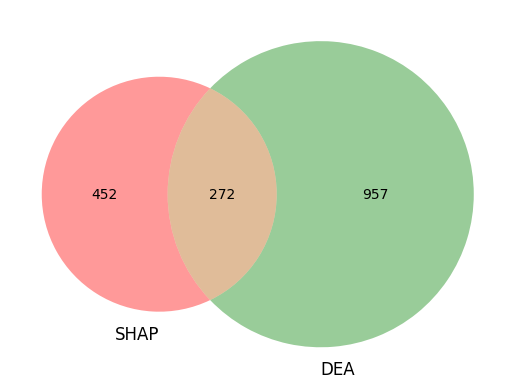

In [9]:
venn2(subsets = [set(feature_nonZero), set(dea_genes.keys())], set_labels = ('SHAP', 'DEA'))
plt.show()

Feature important for SHAP not detected by DEA

In [10]:
print(len(set.difference(set(feature_nonZero), set(dea_genes.keys()))), set.difference(set(feature_nonZero), set(dea_genes.keys())))

452 {'CYP27A1', 'DALRD3', 'CHN1', 'PIEZO1', 'GNAI3', 'NDUFAF5', 'TXNRD1', 'C1orf56', 'USP1', 'XRCC3', 'RAB5IF', 'SZRD1', 'CCNE1', 'AQP3', 'PRKAR1A', 'MYO1B', 'TMEM222', 'DARS2', 'ZSCAN18', 'MFN2', 'NRBF2', 'P4HA1', 'CAPRIN1', 'SLC7A7', 'NIBAN1', 'UPK3A', 'RCVRN', 'DHX40', 'HLCS', 'LAMP5', 'AFAP1', 'PARM1', 'ADAT1', 'SNX4', 'NLK', 'DBNDD1', 'SLC4A1', 'SLA', 'MYDGF', 'ZNF271P', 'ASCC1', 'YJU2B', 'ELOVL1', 'DNAJA3', 'PILRA', 'OTOF', 'LPCAT1', 'TAF6', 'COL5A1', 'COLGALT2', 'DPY19L4', 'MAST2', 'PCBP1', 'MBTPS1', 'TENT5C', 'NIT1', 'RPSA', 'CCL2', 'LTA4H', 'EMD', 'KLF7', 'GMDS', 'ABITRAM', 'YWHAE', 'FZD2', 'CANT1', 'RAB27A', 'SLC12A9', 'NKRF', 'FUZ', 'ITK', 'F2RL1', 'DERA', 'GZMH', 'ERICH1', 'UNC50', 'EPHB1', 'NOTCH1', 'FRG1', 'OAS2', 'ARSB', 'CHUK', 'CD163', 'STAG2', 'PTPN6', 'ACSS3', 'GLUD1', 'NOP53', 'HSPA5', 'KHNYN', 'HADHA', 'WRNIP1', 'EGR1', 'TESC', 'TMEM214', 'RPL14', 'EIF2AK3', 'HMGN4', 'HOXB5', 'TNFSF8', 'NFYA', 'TRIB2', 'DDOST', 'PRR3', 'CITED2', 'USP13', 'LDAH', 'KIR2DL4', 'HYPK', 

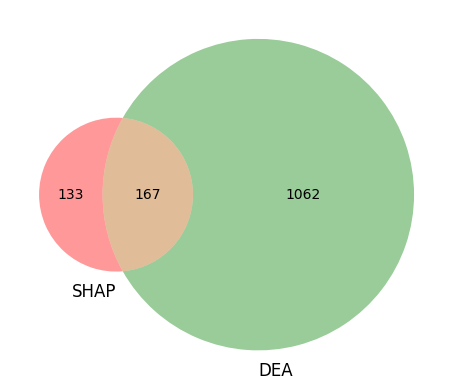

In [11]:
venn2(subsets = [set(feature_nonZero[:300]), set(dea_genes.keys())], set_labels = ('SHAP', 'DEA'))
plt.show()

Known feature important for MS

In [12]:
limit = None

for gene in ["GABPA", "CTCF", "EGR1", "YY1", "SPI1", "CLOCK", "ARNTL", "BACH1", "GFI1", "IFNB1", "MOG",  "MBP", "CD42", "IFNG", "IL17A", "IL10", "TNF", "IL1B", "IL6", "TNFRSF1A", "CYP27B1", "IL7R", "HLA-DRB1", "HLA-DRB5", "IL2RA"]:
    if gene in dataset.columns:
        if gene in feature_nonZero[:limit] and gene in list(sorted_dea_genes.keys())[:limit]:
            print(gene, "Both")
        elif gene in feature_nonZero[:limit]:
            print(gene, "SHAP")
        elif gene in list(sorted_dea_genes.keys())[:limit]:
            print(gene, "DEA")
        else:
            print(gene, "None")
    else:
        print(gene, "Not in dataset")

GABPA DEA
CTCF Not in dataset
EGR1 SHAP
YY1 None
SPI1 None
CLOCK None
ARNTL Not in dataset
BACH1 None
GFI1 DEA
IFNB1 Not in dataset
MOG Not in dataset
MBP DEA
CD42 Not in dataset
IFNG Not in dataset
IL17A Not in dataset
IL10 Not in dataset
TNF None
IL1B SHAP
IL6 Not in dataset
TNFRSF1A None
CYP27B1 Not in dataset
IL7R Not in dataset
HLA-DRB1 Both
HLA-DRB5 Both
IL2RA SHAP


<h2>xxAI Analysis</h2>

In [11]:
color = ['red', 'navy', 'grey', 'yellow', 'green', 'purple', 'pink', 'brown']
classiDataset = ['GSE41848', 'GSE41849', 'GSE146383', 'GSE13732', 'GSE136411', 'GSE17048', 'GSE41890', 'GSE21942']
classiLabel = ['Control', 'MS']
colorLabel = ['Black', 'Orange']
classiGender = ['Female', 'Male']
colorGender = ['Red', 'Blue']

dataset = pd.read_csv('../../Dataset/MergedDatasetFullCombatDeclustered_symbol.csv')
dataset['Gender'] = joblib.load("genderFull.pkl")
dataset

SampleID      PatientID  Label     TRAK2  \
0                0-GSM1026056_600009.0001  0-600009.0001      1  9.597071   
1     0-GSM1026057_600009.0001-FollowUp_1  0-600009.0001      1  9.039251   
2                 0-GSM1026058_41461.0001   0-41461.0001      1  8.791386   
3                 0-GSM1026059_41462.0001   0-41462.0001      1  9.373170   
4                0-GSM1026060_600029.0001  0-600029.0001      1  9.076237   
...                                   ...            ...    ...       ...   
1033                      7-GSM545842_M10          7-M10      1  8.955028   
1034                      7-GSM545843_M11          7-M11      1  9.101329   
1035           7-GSM545844_M11-FollowUp_1          7-M11      1  9.271382   
1036                      7-GSM545845_M12          7-M12      1  9.351712   
1037           7-GSM545846_M12-FollowUp_1          7-M12      1  9.292476   

       MARCHF5      AVIL    CLSTN1    TAPBPL     TRIM38     GDF11  ...  \
0     6.172613  6.183003  7.619254  8.451946   9.674435  6.629841  ...   
1     6.532620  6.350718  7.841904  8.629886   9.565077  6.824635  ...   
2     6.548371  6.933703  7.279164  8.166420   9.772884  6.515736  ...   
3     7.116801  7.012218  7.233344  8.338171   9.725869  6.458866  ...   
4     7.104757  6.515409  7.488312  8.355218  10.033820  6.189225  ...   
...        ...       ...       ...       ...        ...       ...  ...   
1033  6.642111  6.639887  7.445428  8.359939   9.682368  6.735513  ...   
1034  6.715089  6.611748  7.449074  8.112262   9.634445  6.503292  ...   
1035  6.670915  6.620238  7.404586  8.119619   9.650254  6.681918  ...   
1036  6.679360  6.581669  7.442222  8.282929   9.638524  6.409742  ...   
1037  6.678637  6.662260  7.397570  8.343229   9.653412  6.024943  ...   

         NDUFA1      PEX7      NET1     TMED5      FADD     URGCP      MDM4  \
0     10.188925  6.535162  7.816546  9.744325  8.263995  7.352167  8.662674   
1     10.255465  6.432247  7.916046  9.687447  8.241698  7.349809  8.445578   
2     10.101372  6.495679  8.104559  9.632676  8.242744  7.205897  8.071700   
3     10.314306  6.353293  7.386301  9.769748  8.376067  7.312015  8.425182   
4     10.243407  6.334131  7.331289  9.626407  8.217957  7.254979  7.917974   
...         ...       ...       ...       ...       ...       ...       ...   
1033  10.312671  5.698647  7.380776  9.698418  8.155223  7.361099  8.327890   
1034  10.357670  6.671623  7.428976  9.763741  8.122246  7.262578  8.175908   
1035  10.208762  6.715863  7.705067  9.785031  8.103883  7.362873  8.131763   
1036  10.401224  6.861365  7.413546  9.703183  8.135620  7.244212  8.187447   
1037  10.255236  6.813299  7.595989  9.750070  8.454906  7.257439  8.178654   

        BMPR1A    EIF1AY  Gender  
0     6.263145  5.084750  Female  
1     7.242537  5.046855  Female  
2     6.124447  5.049761  Female  
3     6.534315  5.051708  Female  
4     6.195773  5.038392  Female  
...        ...       ...     ...  
1033  6.361955  5.504788  Female  
1034  7.282642  5.622606  Female  
1035  7.425195  5.609163  Female  
1036  6.908857  5.568584  Female  
1037  6.913615  5.572668  Female  

[1038 rows x 6672 columns]

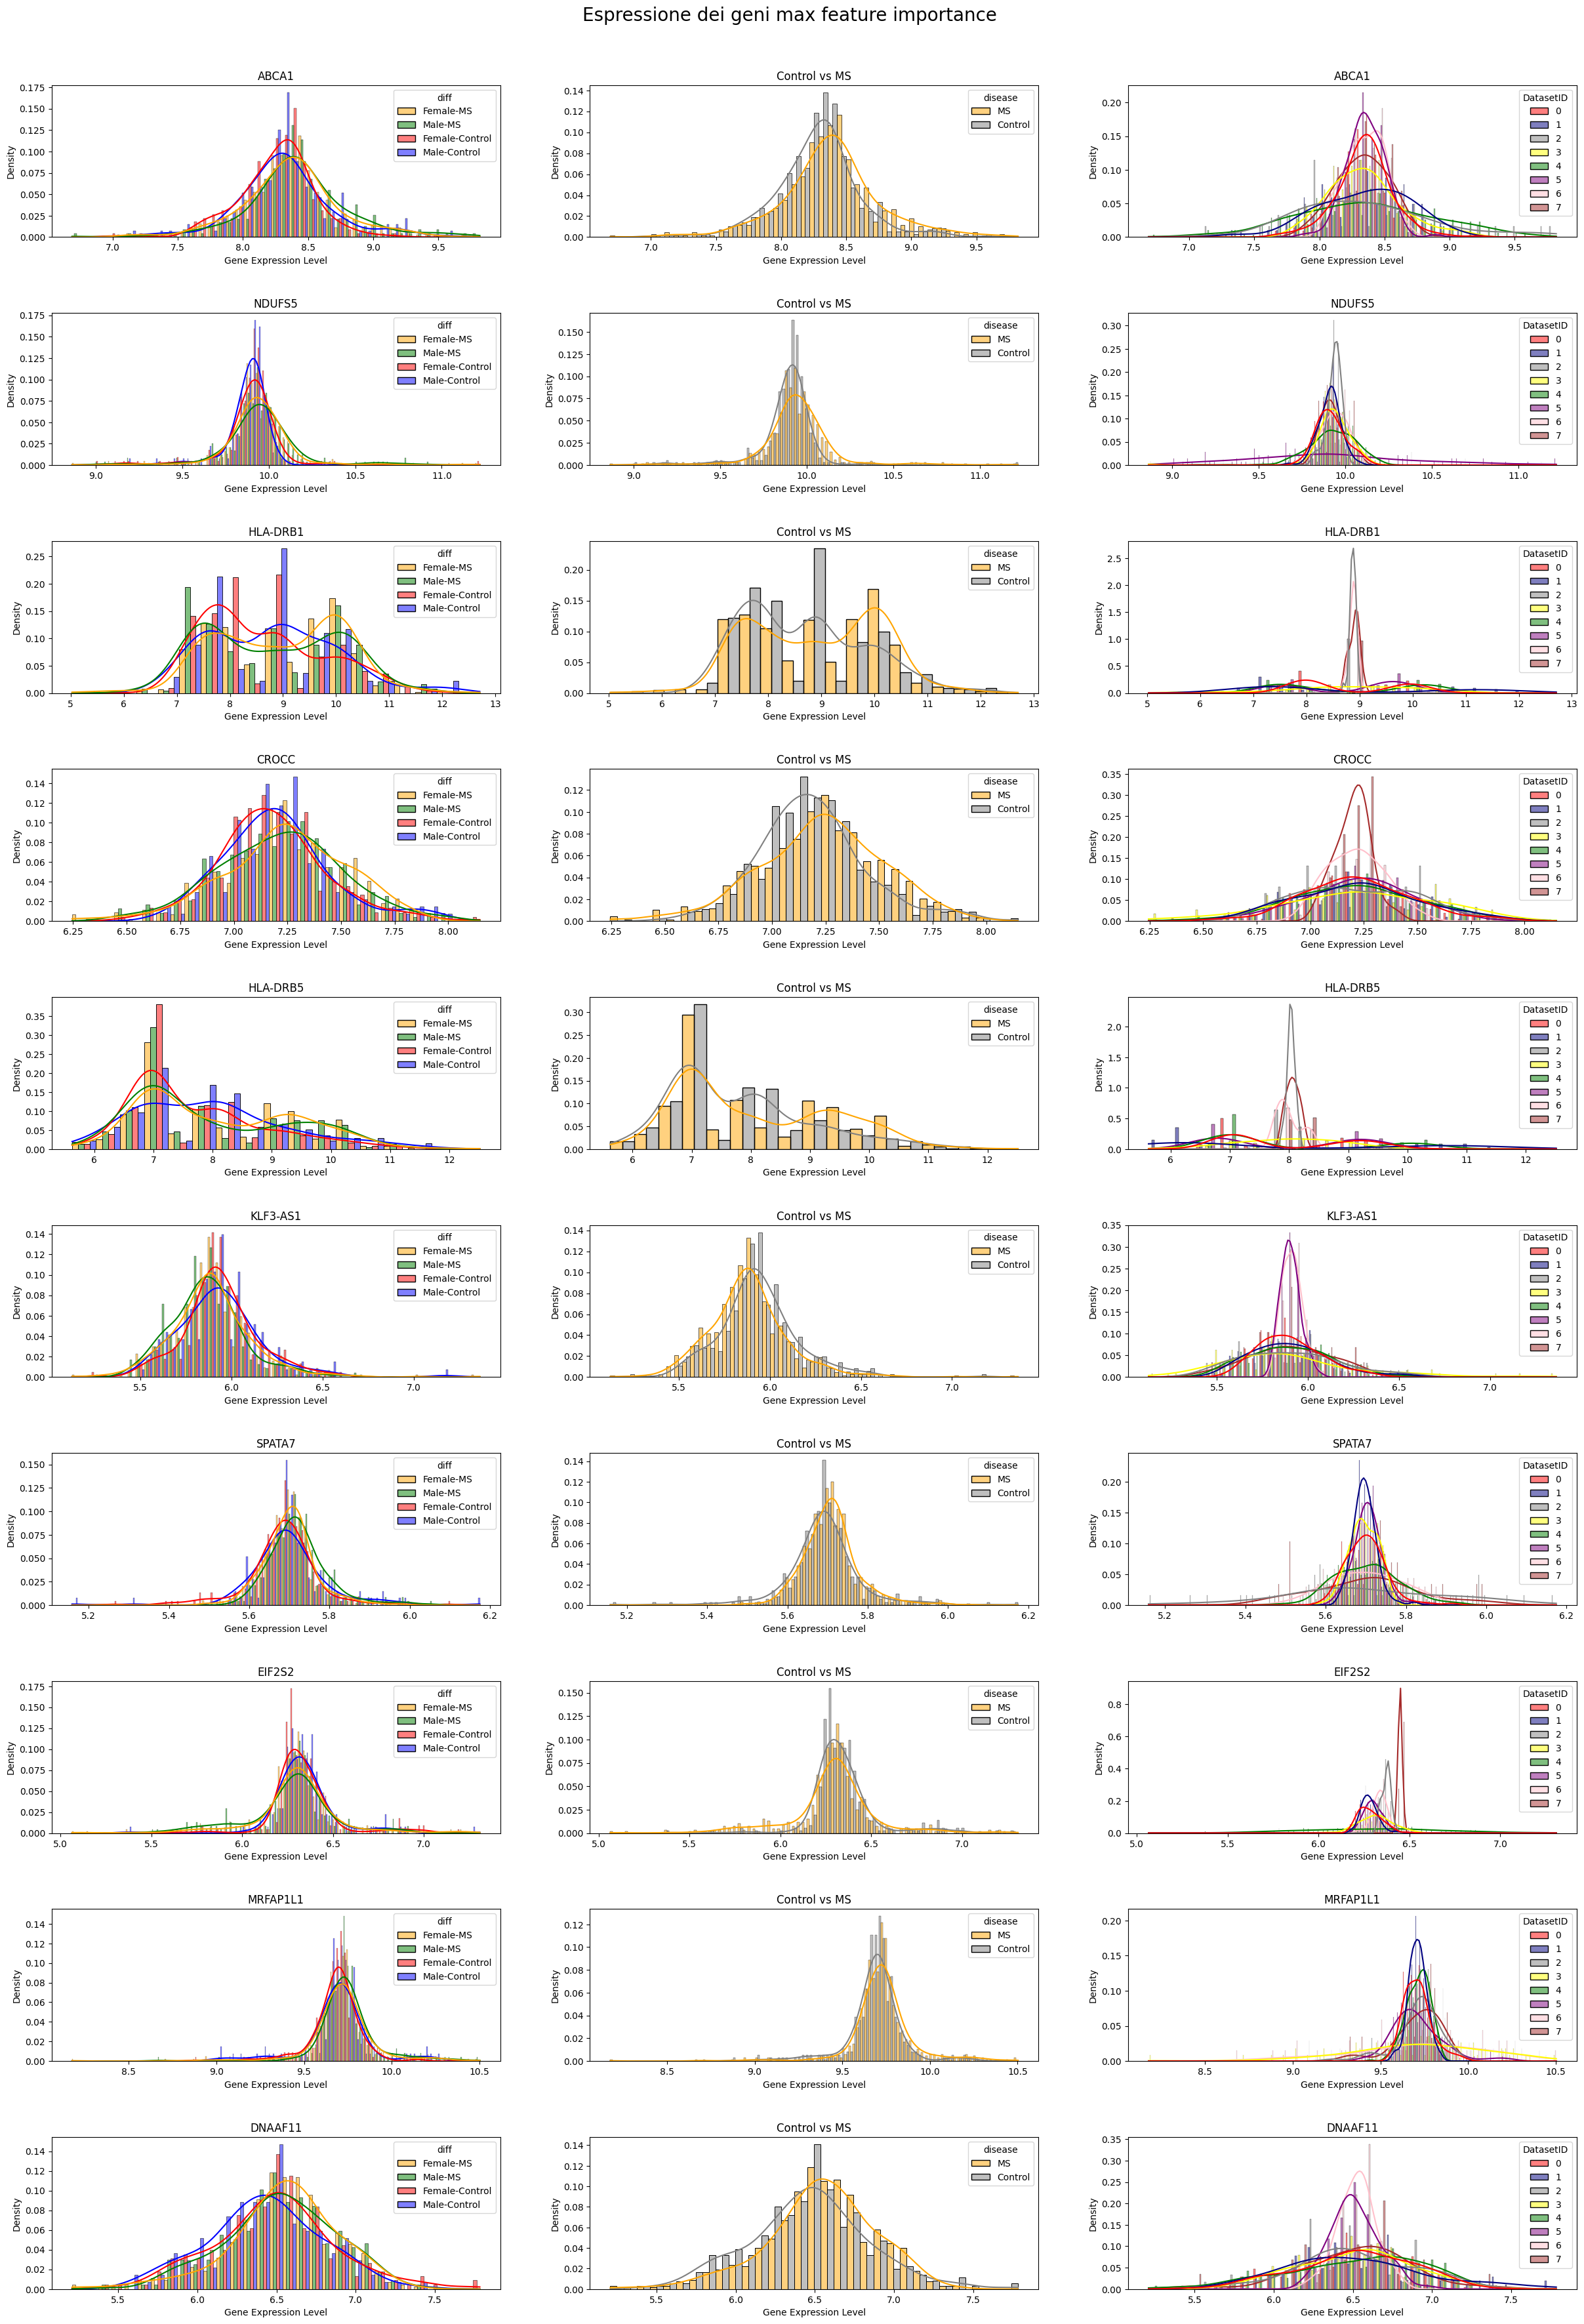

In [13]:
current = dataset.copy()

warnings.filterwarnings("ignore")

current['disease'] = current['Label'].apply(lambda x: 'MS' if x == 1 else 'Control')
current['diff'] = current['Gender']+"-"+current['disease'].astype(str)
current['DatasetID'] = current['SampleID'].apply(lambda x: x.split("-")[0])

gene_list = feature_nonZero[:10]

fig, axes = plt.subplots(len(gene_list), 3, figsize=(30, 40))

for i, gene in enumerate(gene_list):
    sns.histplot(data=current, x=gene, hue='diff', stat="probability",
                 kde=True, palette={'Female-MS':'orange', 'Female-Control':'red', 'Male-MS':'green', 'Male-Control':'blue'}, multiple='dodge', common_norm=False, ax=axes[i][0])
    axes[i][0].set_title(gene)
    axes[i][0].set_xlabel("Gene Expression Level")
    axes[i][0].set_ylabel("Density")


    sns.histplot(data=current, x=gene, hue='disease', stat="probability",
                 kde=True, palette={'Control': 'grey', 'MS': 'orange'}, multiple='dodge', common_norm=False, ax=axes[i][1])
    axes[i][1].set_title('Control vs MS')
    axes[i][1].set_xlabel("Gene Expression Level")
    axes[i][1].set_ylabel("Density")

    sns.histplot(data=current, x=gene, hue='DatasetID', stat="probability",
                 kde=True, palette={'0':'red', '1':'navy', '2':'grey', '3':'yellow', '4':'green', '5':'purple', '6':'pink', '7':'brown'}, multiple='dodge', common_norm=False, ax=axes[i][2])
    axes[i][2].set_title(gene)
    axes[i][2].set_xlabel("Gene Expression Level")
    axes[i][2].set_ylabel("Density")

    plt.subplots_adjust(hspace=0.5)

plt.suptitle("Espressione dei geni max feature importance", fontsize=20)
plt.subplots_adjust(top=0.95)
plt.show()

<h3>Insert ex clusters</h3>

In [30]:
clusters = joblib.load("uniqueClustersFull.pkl")
clusters

{('DDX3Y', 'EIF1AY', 'RPS4Y1', 'TXLNGY', 'UTY', 'PRKY'): 'EIF1AY'}

In [32]:
for key, value in clusters.items():
    print(value, value in feature_nonZero)

EIF1AY False


<h3>Ablation</h3>

In [23]:
dataset = pd.read_csv('../../Dataset/MergedDatasetFullCombatDeclustered_symbol.csv')

gruppi = dataset.groupby('PatientID')

def sanity_check(gruppi):
    for group_name, group_data in gruppi:
        if 'Control' in group_data['SampleID'].iloc[0]:
            for e in group_data['SampleID']:
                if not 'Control' in e:
                    print("Errore in gruppo:", group_name)
                    break
        else:
            for e in group_data['SampleID']:
                if 'Control' in e:
                    print("Errore in gruppo:", group_name)
                    break

sanity_check(gruppi)

splitter = GroupShuffleSplit(n_splits=2, test_size=0.25, random_state = 42)
split = splitter.split(dataset, groups=dataset['PatientID'])
train_inds, test_inds = next(split)

train = dataset.iloc[train_inds].sample(frac=1, random_state=42)
test = dataset.iloc[test_inds].sample(frac=1, random_state=42)

print("Dataset di train:")
print(train.shape)
print("I malati sono: ", sum(train['Label'] == 1))
print("I sani sono: ", sum(train['Label'] == 0))

print("\nDataset di test:")
print(test.shape)
print("I malati sono: ", sum(test['Label'] == 1))
print("I sani sono: ", sum(test['Label'] == 0))

y_train = train['Label']
x_train = train.drop(columns=['SampleID', 'Label', 'PatientID'])

y_test = test['Label']
x_test = test.drop(columns=['SampleID', 'Label', 'PatientID'])

Dataset di train:
(772, 6671)
I malati sono:  510
I sani sono:  262

Dataset di test:
(266, 6671)
I malati sono:  166
I sani sono:  100


In [24]:
model = joblib.load("bayesianOptResult.pkl").best_estimator_
originalScore = f1_score(y_test, model.predict(x_test))

def calcScores(x_test, y_test, model, originalScore):
    scores = {col: 0 for col in x_test.columns}
    i = 1
    for exclude in range(x_train.shape[1]):
        x = x_test.copy()
        x[x.columns[exclude]] = x[x.columns[exclude]].mean()
        scores[x.columns[exclude]] = originalScore / f1_score(y_test, model.predict(x))
        print(i)
        i += 1
    return scores

scores = calcScores(x_test, y_test, model, originalScore)
# joblib.dump(scores, 'xgbDefFull_ablationScores.pkl')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [25]:
# scores = joblib.load('xgbDefFull_ablationScores.pkl')
sorted_scores = dict(sorted(scores.items(), key=lambda item: item[1], reverse=True))
bestFeatures = {key: value for key, value in sorted_scores.items() if value > 1.0}
worstFeatures = {key: value for key, value in sorted_scores.items() if value < 1.0}
print("Le feature migliori sono: ", len(bestFeatures), bestFeatures)
print("Le feature rumorose sono: ", len(worstFeatures), worstFeatures)

print(list(bestFeatures.keys()))

Le feature migliori sono:  118 {'HDC': 1.0157974300831443, 'GPR68': 1.0129440665154952, 'SDK2': 1.011768018018018, 'COX14': 1.011768018018018, 'ABCA1': 1.0112633181126331, 'CTSG': 1.0100907029478459, 'NDUFS5': 1.0100907029478459, 'RMC1': 1.0089339339339338, 'CD1E': 1.0089339339339338, 'PDK4': 1.00779269202088, 'KLF4': 1.00779269202088, 'FKBP5': 1.00779269202088, 'KCNK3': 1.00779269202088, 'PTPRM': 1.00779269202088, 'CUBN': 1.00779269202088, 'GJA5': 1.00779269202088, 'CYP27A1': 1.00609984984985, 'ZNF154': 1.00609984984985, 'CD151': 1.0049776286353467, 'VASP': 1.0049776286353467, 'ATF1': 1.0049776286353467, 'HUWE1': 1.0049776286353467, 'MAMLD1': 1.0049776286353467, 'CCT7': 1.0049776286353467, 'PPP2R1A': 1.0049776286353467, 'LPCAT3': 1.0038703703703704, 'CSTF2T': 1.0038703703703704, 'LAMP5': 1.0038703703703704, 'CASP8': 1.0038703703703704, 'POLD3': 1.0038703703703704, 'TSC2': 1.0038703703703704, 'RBMS2': 1.0038703703703704, 'STUM': 1.0038703703703704, 'CLPP': 1.0038703703703704, 'CTSK': 1

In [33]:
intersect = [feature for feature in bestFeatures.keys() if feature in expl_sorted.keys()]
print(len(intersect), intersect)

118 ['HDC', 'GPR68', 'SDK2', 'COX14', 'ABCA1', 'CTSG', 'NDUFS5', 'RMC1', 'CD1E', 'PDK4', 'KLF4', 'FKBP5', 'KCNK3', 'PTPRM', 'CUBN', 'GJA5', 'CYP27A1', 'ZNF154', 'CD151', 'VASP', 'ATF1', 'HUWE1', 'MAMLD1', 'CCT7', 'PPP2R1A', 'LPCAT3', 'CSTF2T', 'LAMP5', 'CASP8', 'POLD3', 'TSC2', 'RBMS2', 'STUM', 'CLPP', 'CTSK', 'ICMT', 'TCF7', 'PCMT1', 'HADHA', 'LRRC37BP1', 'RAB27A', 'SRSF11', 'EPHX2', 'ALPP', 'ZNF432', 'THRA', 'MYOF', 'COTL1', 'FRZB', 'DICER1', 'GANAB', 'IK', 'MAP4K5', 'OSBPL1A', 'GALNT6', 'SPATA2L', 'TAPT1', 'SCCPDH', 'RGS14', 'GTF2H5', 'SIAH1', 'FOXRED2', 'ZNF135', 'CPSF1', 'RMND1', 'USP47', 'RPS28', 'STK16', 'EIF3H', 'CAPZB', 'ENSA', 'CYB5B', 'UQCR10', 'AFAP1', 'MORF4L1', 'TBK1', 'RPS25', 'DDIT4', 'ADSS2', 'TRA2A', 'IL27RA', 'SECISBP2', 'EIF2AK2', 'PPM1D', 'NCOA3', 'CTPS1', 'CTBP2', 'CSNK1D', 'MED28', 'AHI1', 'LPAR6', 'RFTN1', 'DBN1', 'CDKN1C', 'SNRNP25', 'PPARA', 'RBL1', 'SMAGP', 'MSMO1', 'ADRB2', 'ZNF706', 'CXCR4', 'TMX4', 'ANXA4', 'PDCL', 'ERO1A', 'CD163', 'FMO5', 'MSL3', 'CAVIN3